# Проект: классификация

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
import optuna
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [95]:
data = pd.read_csv('data/bank_fin.csv', sep = ';')

In [96]:
display(data.info())
display(data.describe()) 
display(data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


None

,age,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0 $,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
6,56,management,married,tertiary,no,"830,00 $",yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
7,60,retired,divorced,secondary,no,"545,00 $",yes,no,unknown,6,may,1030,1,-1,0,unknown,yes
8,37,technician,married,secondary,no,"1,00 $",yes,no,unknown,6,may,608,1,-1,0,unknown,yes
9,28,services,single,secondary,no,NaN,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes


In [97]:
df = data.copy()

In [98]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
# Check for any null values in the dataset
missing_values = df.isnull().sum()

# Print columns with missing values and their counts
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
balance    25
dtype: int64


### Задание 2

In [99]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код

# Count the occurrences of each unique value in the 'job' column
job_value_counts = df['job'].value_counts(dropna=False)

# Print the frequencies of each unique job description
print(job_value_counts)

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64


### Задание 3

In [100]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

# Clean and convert the 'balance' column
df['balance'] = df['balance'].str.replace(' ', '').str.replace(',', '.').str.replace('00$', '').str.replace('$', '').astype(float)

# Verify the conversion by checking the data type and the first few rows
print(df['balance'].dtype)
print(df['balance'].head())

float64
0    2343.0
1      45.0
2    1270.0
3    2476.0
4     184.0
Name: balance, dtype: float64


In [101]:
# Calculate the average value of the 'balance' feature
average_balance = df['balance'].mean()

# Round the average to three decimal places
average_balance_rounded = round(average_balance, 3)

print(f"Average balance: {average_balance_rounded}")

Average balance: 1529.129


### Задание 4

In [102]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код

# Impute missing values in 'balance' with the median
median_balance = df['balance'].median()
df['balance'].fillna(median_balance, inplace=True)

# Verify that there are no missing values in 'balance'
print(df['balance'].isnull().sum())

0


### Задание 5

In [103]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код

# Replace 'unknown' in 'job' and 'education' with the modal value
job_mode = df['job'].mode()[0]
education_mode = df['education'].mode()[0]

df['job'].replace('unknown', job_mode, inplace=True)
df['education'].replace('unknown', education_mode, inplace=True)

# Verify that there are no missing values in 'balance', 'job', and 'education'
print("Missing values in 'balance':", df['balance'].isnull().sum())
print("Counts of each job type:\n", df['job'].value_counts())
print("Counts of each education level:\n", df['education'].value_counts())

Missing values in 'balance': 0
Counts of each job type:
 job
management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: count, dtype: int64
Counts of each education level:
 education
secondary    5973
tertiary     3689
primary      1500
Name: count, dtype: int64


### Задание 6

In [104]:
# удалите все выбросы для признака balance
# ваш код

# copy the dataset without outliners cleaning to proceeding with another methods
df_save = df.copy()

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Calculate the lower and upper bounds for outliers
lower_bound_tukey = Q1 - 1.5 * IQR
upper_bound_tukey = Q3 + 1.5 * IQR

# Round the bounds to the nearest integer
lower_bound_tukey = int(round(lower_bound_tukey))
upper_bound_tukey = int(round(upper_bound_tukey))

# Filter the data to remove outliers
remaining_objects_tukey = df[(df['balance'] >= lower_bound_tukey) & (df['balance'] <= upper_bound_tukey)]

outliers_tukey = df.drop(remaining_objects_tukey.index) # get the ouliers objects

# DATA RECORDING
df = remaining_objects_tukey

# Output the results
print(f"Lower bound: {lower_bound_tukey}")
print(f"Upper bound: {upper_bound_tukey}")
print(f"Number of objects remaining after removing outliers: {df.shape[0]}")

Lower bound: -2241
Upper bound: 4063
Number of objects remaining after removing outliers: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

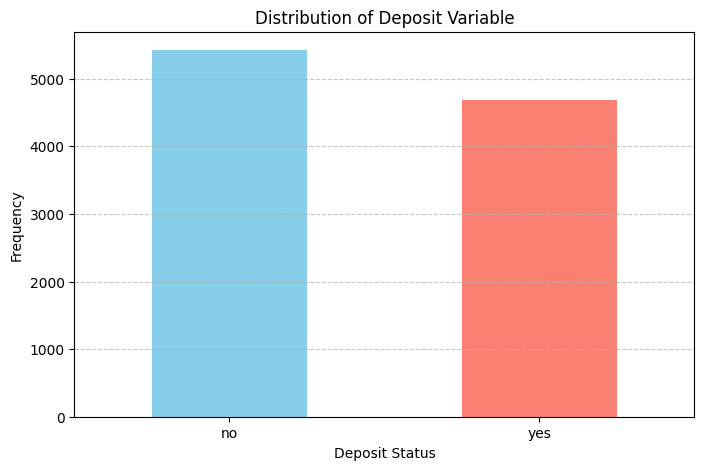

deposit
no     5424
yes    4681
Name: count, dtype: int64


In [130]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код

# Calculate the frequency of each category in the 'deposit' column
deposit_counts = df['deposit'].value_counts()

# Create a bar plot to visualize the distribution of the target variable
plt.figure(figsize=(8, 5))
deposit_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Deposit Variable')
plt.xlabel('Deposit Status')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print the frequencies
print(deposit_counts)

### Задания 2 и 3

,count,mean,std,min,25%,50%,75%,max
age,10105.0,40.895497,11.734931,18.0,32.0,38.0,48.0,95.0
balance,10105.0,807.653538,994.151966,-2049.0,95.0,445.0,1227.0,4063.0
day,10105.0,15.590302,8.441510,1.0,8.0,15.0,22.0,31.0
duration,10105.0,368.742603,346.651524,2.0,137.0,252.0,490.0,3881.0
campaign,10105.0,2.517170,2.707159,1.0,1.0,2.0,3.0,43.0
pdays,10105.0,51.319644,109.644179,-1.0,-1.0,-1.0,2.0,854.0
previous,10105.0,0.816230,2.243795,0.0,0.0,0.0,1.0,58.0


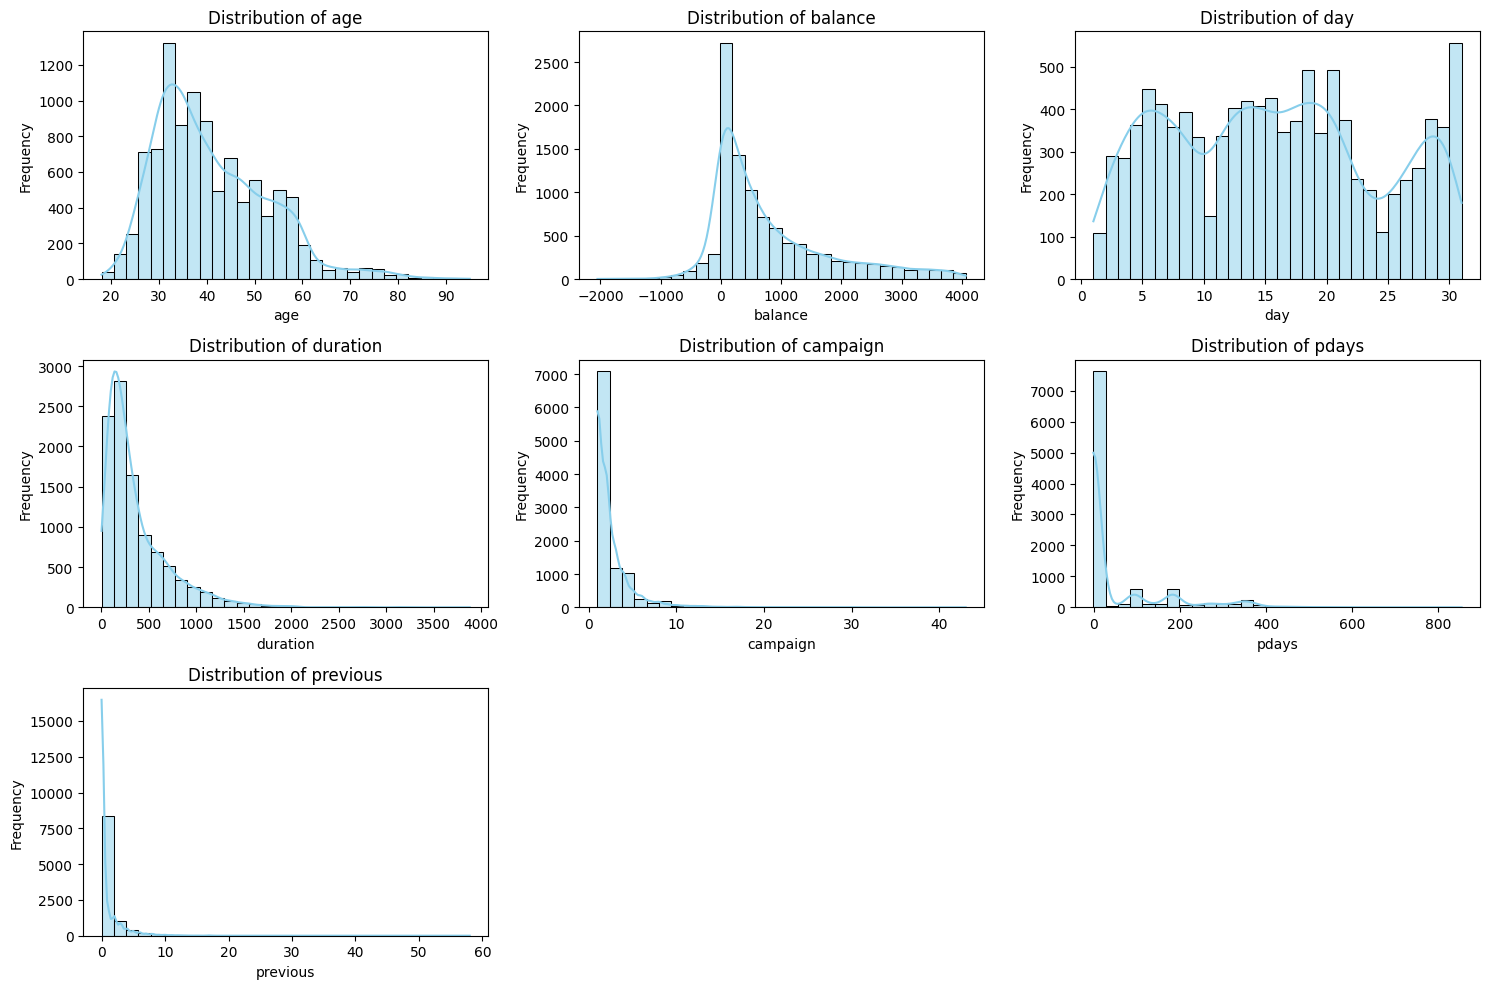

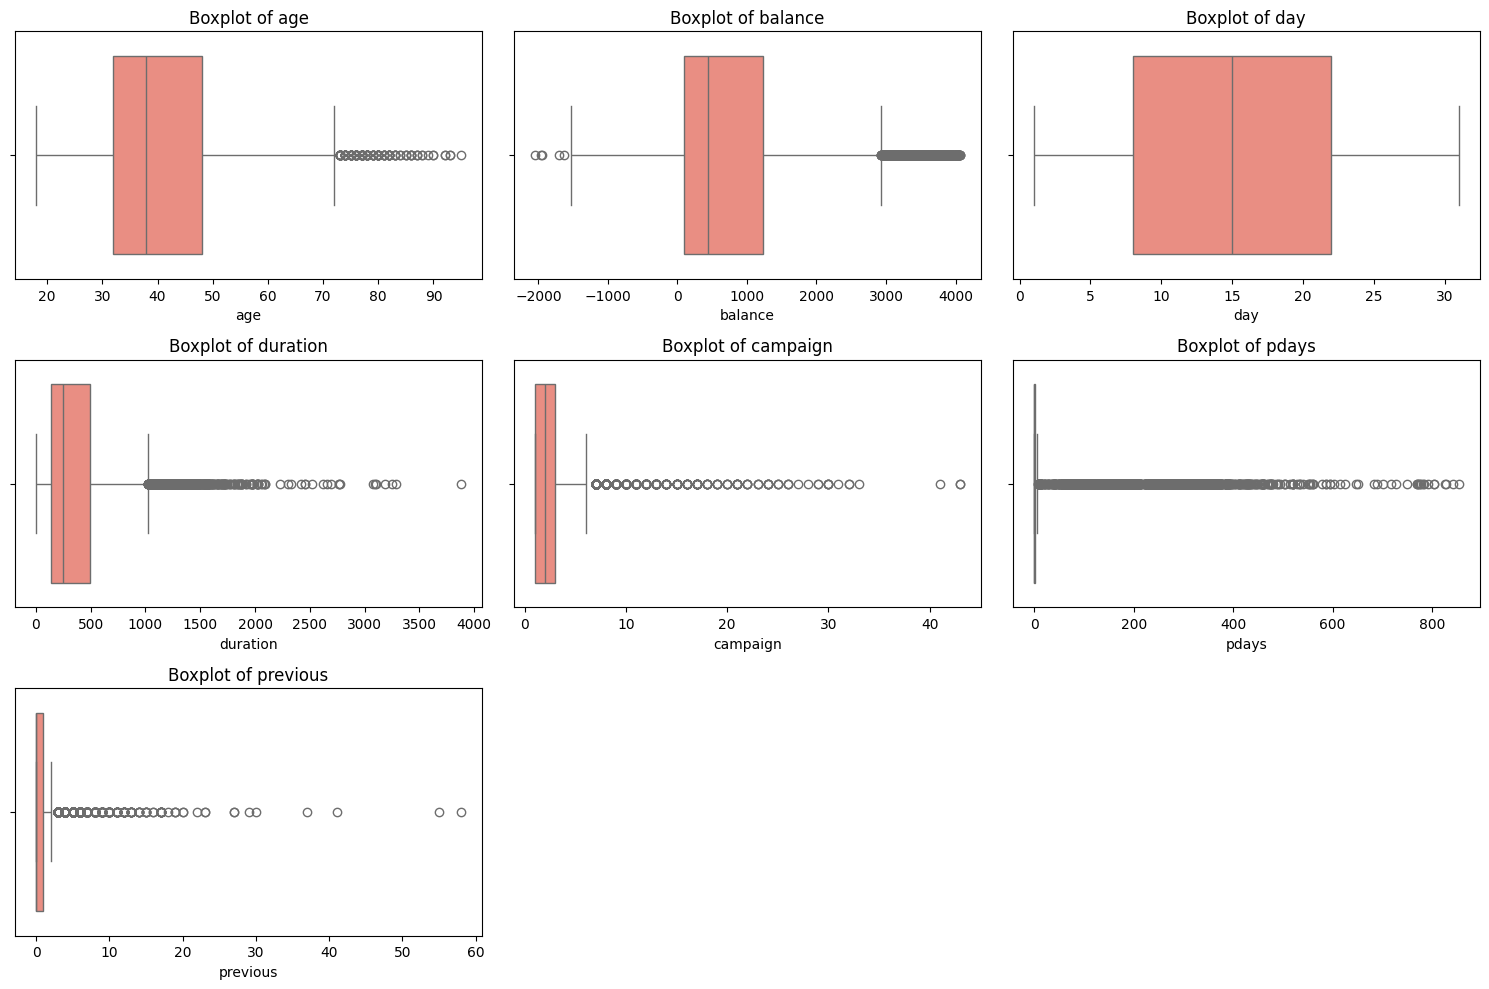

In [131]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

# Select quantitative variables dynamically
quantitative_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate descriptive statistics for quantitative variables
descriptive_stats = df[quantitative_columns].describe().transpose()

# Display descriptive statistics as a DataFrame table
display(pd.DataFrame(descriptive_stats))

# Visualize distributions using histograms and boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(quantitative_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(quantitative_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

### Задания 4 и 5

,count,unique,top,freq
job,10105,11,management,2315
marital,10105,3,married,5715
education,10105,3,secondary,5517
default,10105,2,no,9939
housing,10105,2,no,5243
loan,10105,2,no,8712
contact,10105,3,cellular,7283
month,10105,12,may,2617
poutcome,10105,4,unknown,7570
deposit,10105,2,no,5424


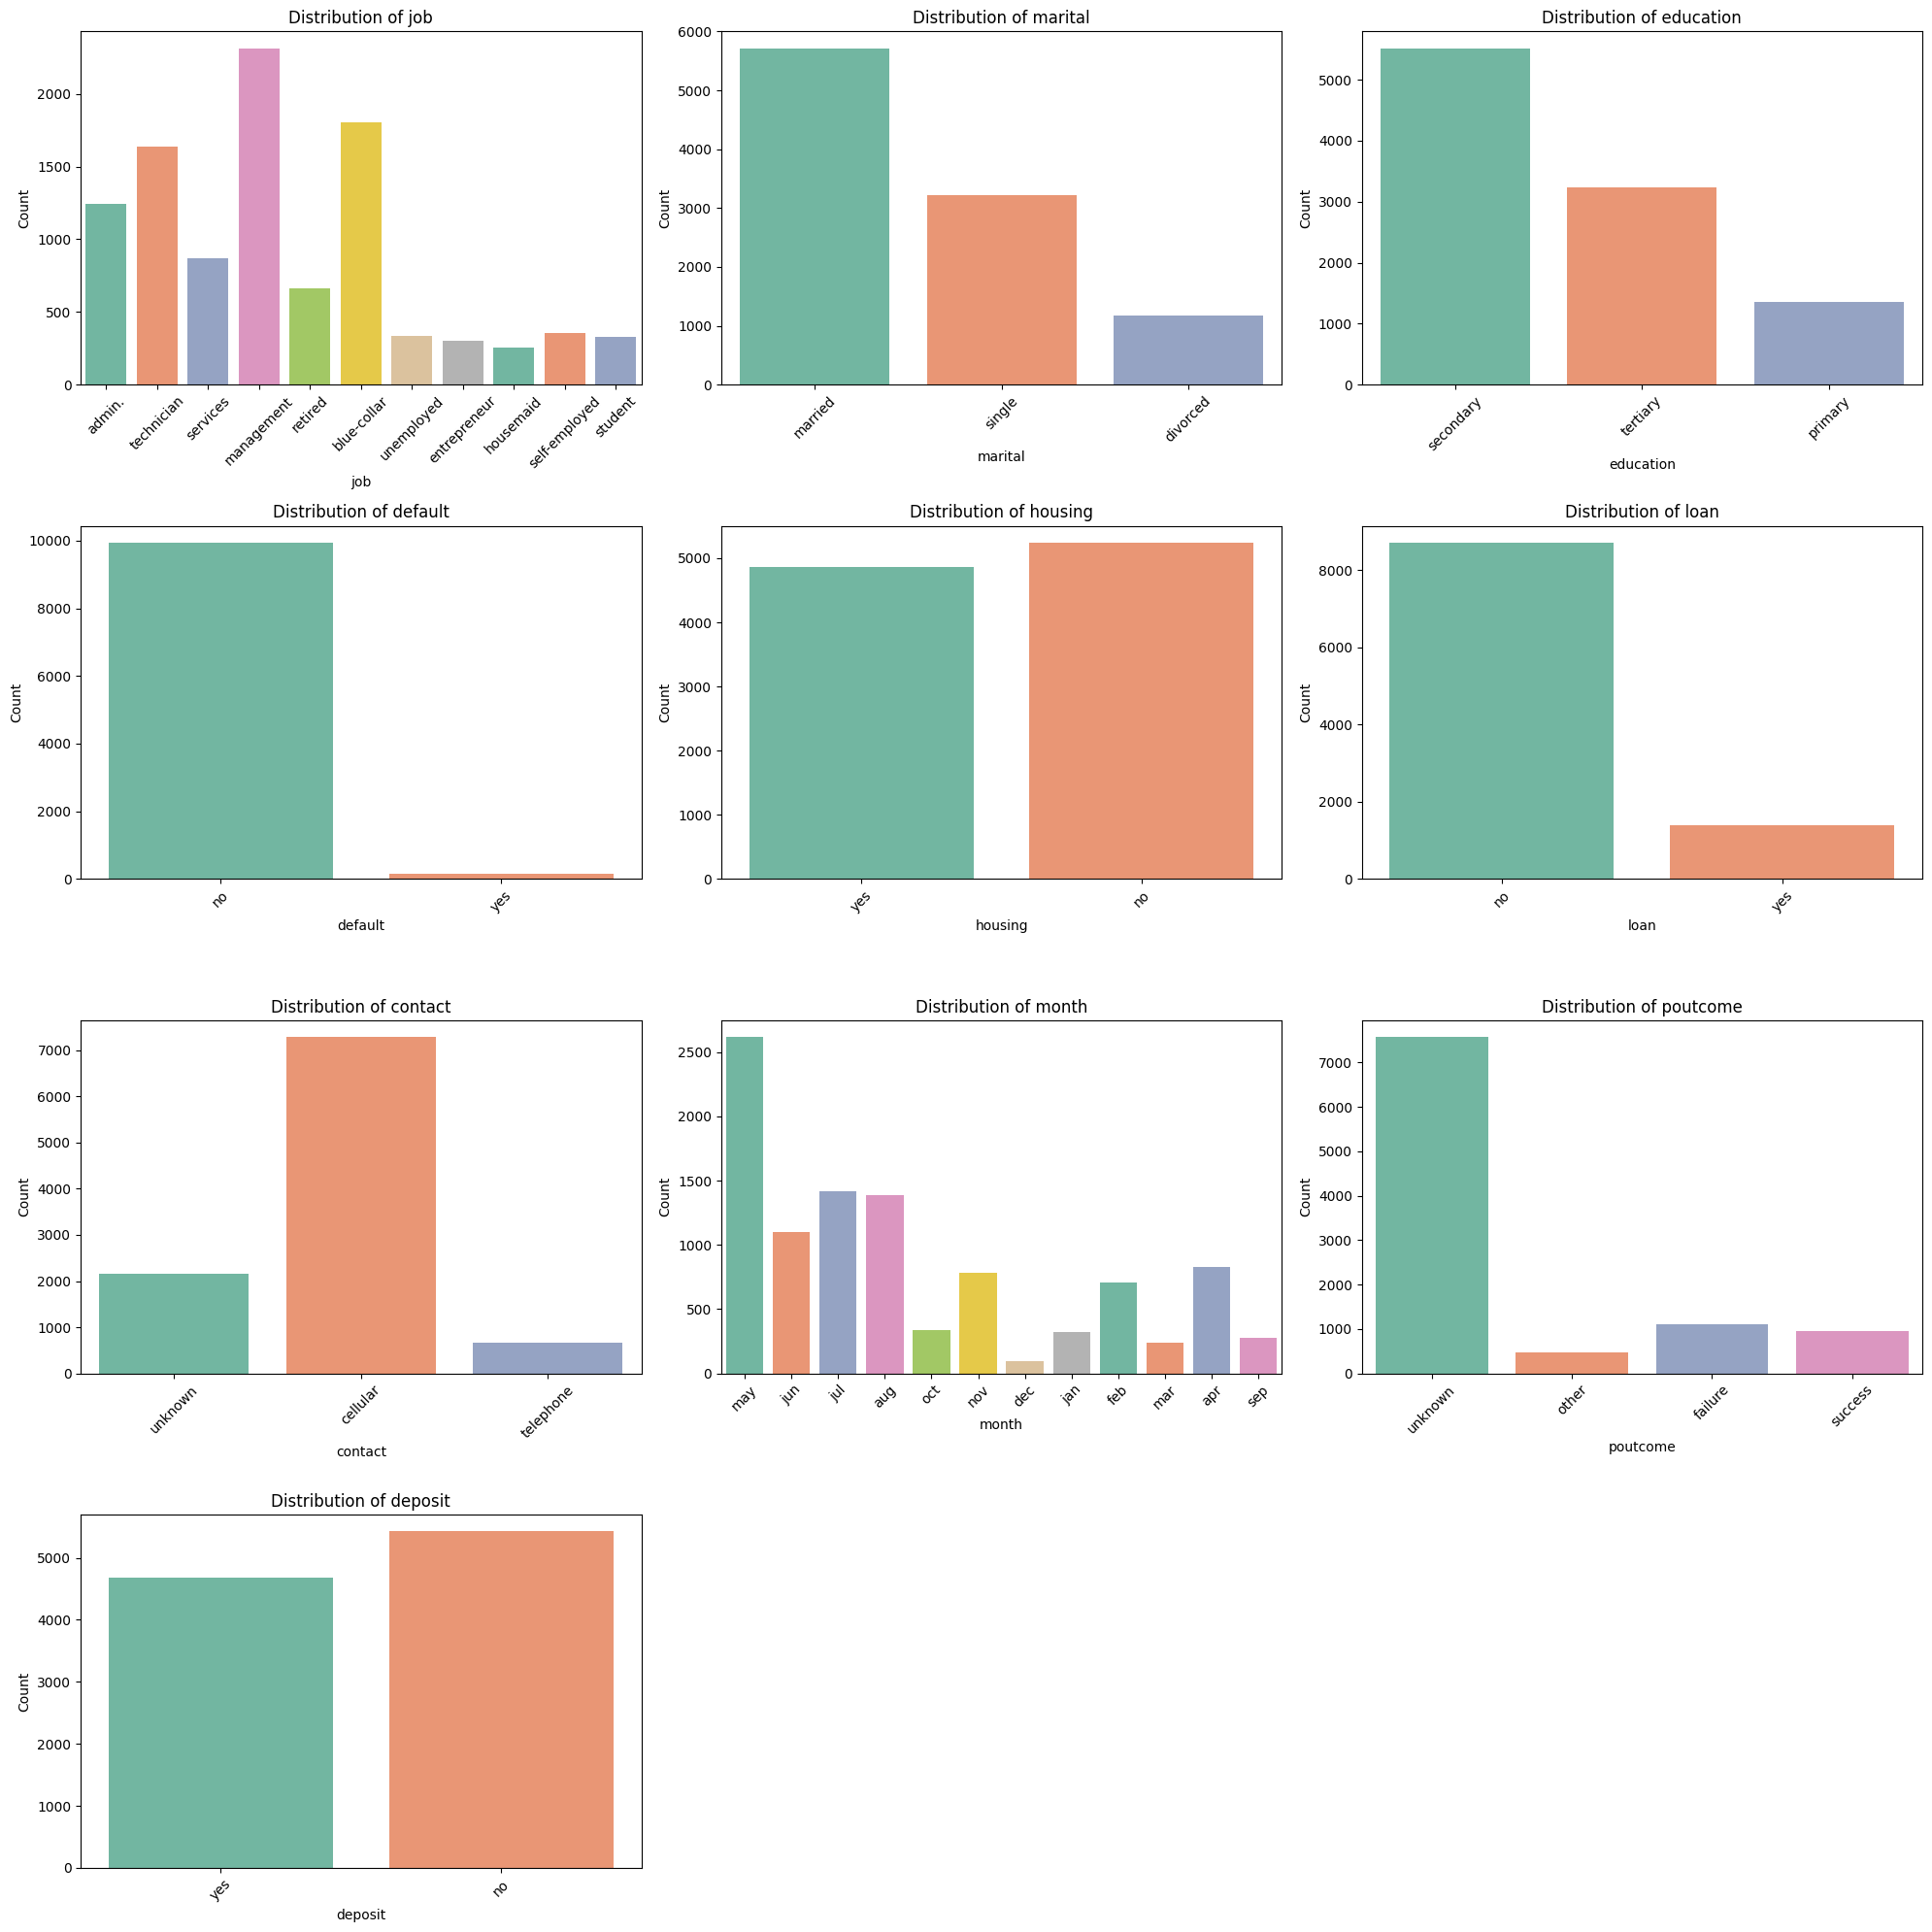

In [132]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

import math
# Select categorical variables
categorical_columns = df.select_dtypes(include=['object']).columns

# Calculate descriptive statistics for categorical variables
categorical_stats = df[categorical_columns].describe().transpose()

# Print descriptive statistics
display(pd.DataFrame(categorical_stats))

# Calculate the number of rows and columns needed for the subplots
n_cats = len(categorical_columns)
n_cols = 3
n_rows = math.ceil(n_cats / n_cols)

# Visualize distributions of categorical variables
plt.figure(figsize=(20, 5 * n_rows))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(data=df, x=col, palette='Set2')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

### Задание 6

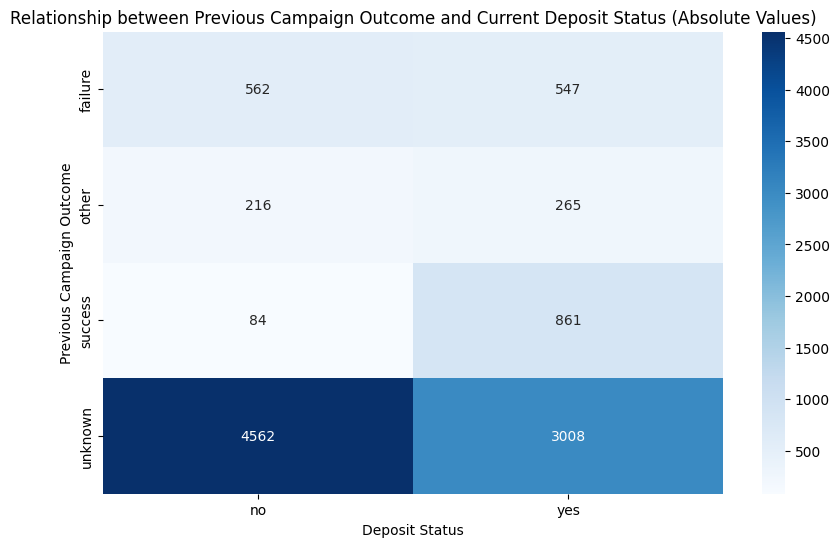

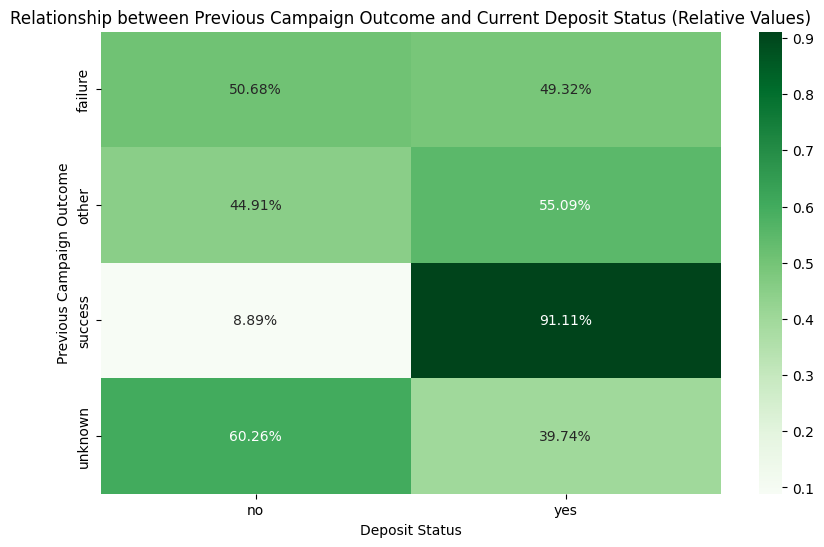

'Absolute Crosstab:'

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


'Relative Crosstab (proportions):'

deposit,no,yes
poutcome,,
failure,0.5068,0.4932
other,0.4491,0.5509
success,0.0889,0.9111
unknown,0.6026,0.3974


In [133]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

# Create crosstabs to analyze the relationship between previous campaign outcome and current deposit status
poutcome_deposit_crosstab_absolute = pd.crosstab(df['poutcome'], df['deposit'])
poutcome_deposit_crosstab_relative = pd.crosstab(df['poutcome'], df['deposit'], normalize='index')

# Visualize the absolute crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(poutcome_deposit_crosstab_absolute, annot=True, fmt='d', cmap='Blues')
plt.title('Relationship between Previous Campaign Outcome and Current Deposit Status (Absolute Values)')
plt.xlabel('Deposit Status')
plt.ylabel('Previous Campaign Outcome')
plt.show()

# Visualize the relative crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(poutcome_deposit_crosstab_relative, annot=True, fmt='.2%', cmap='Greens')
plt.title('Relationship between Previous Campaign Outcome and Current Deposit Status (Relative Values)')
plt.xlabel('Deposit Status')
plt.ylabel('Previous Campaign Outcome')
plt.show()

# Display the crosstabs
display("Absolute Crosstab:")
display(pd.DataFrame(poutcome_deposit_crosstab_absolute))
display("Relative Crosstab (proportions):")
display(pd.DataFrame(round(poutcome_deposit_crosstab_relative,4)))

### Задание 7

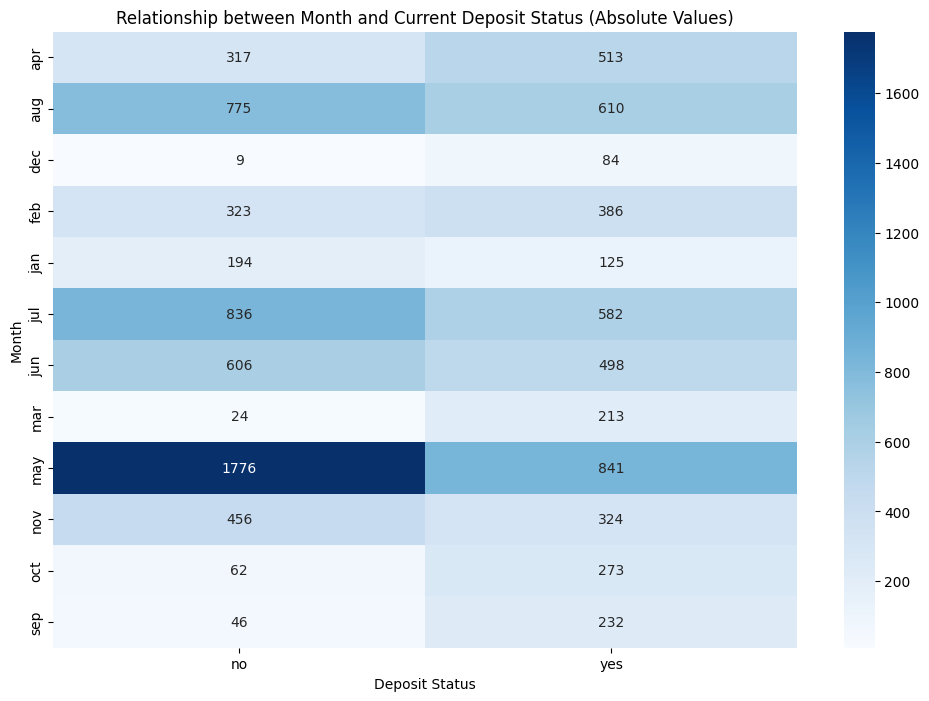

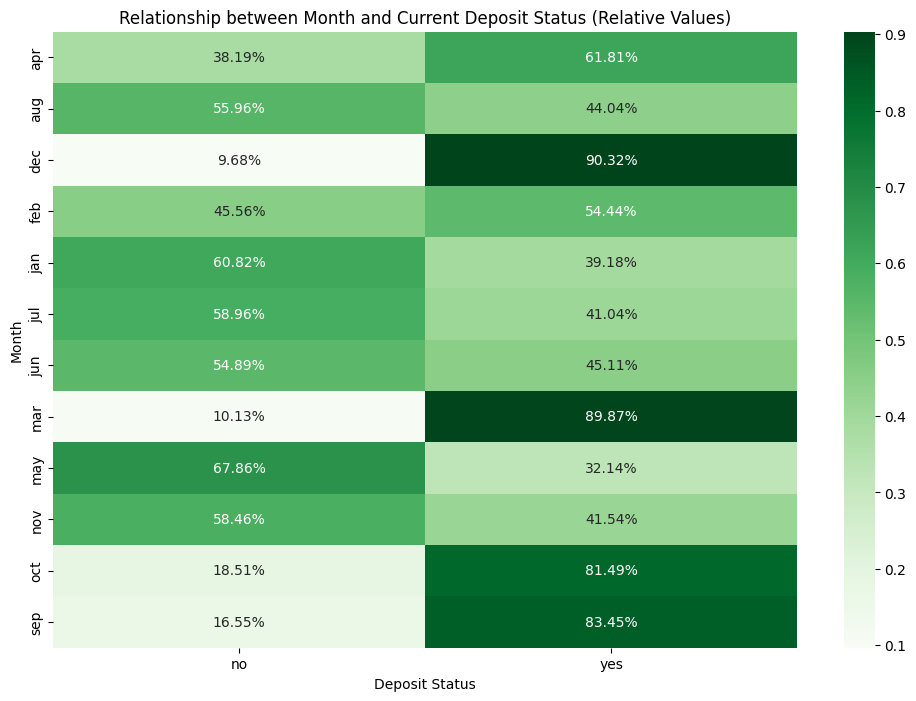

Absolute Crosstab:


deposit,no,yes
month,,
apr,317,513
aug,775,610
dec,9,84
feb,323,386
jan,194,125
jul,836,582
jun,606,498
mar,24,213
may,1776,841



Relative Crosstab (Percentages):


deposit,no,yes
month,,
apr,0.381928,0.618072
aug,0.559567,0.440433
dec,0.096774,0.903226
feb,0.455571,0.544429
jan,0.608150,0.391850
jul,0.589563,0.410437
jun,0.548913,0.451087
mar,0.101266,0.898734
may,0.678640,0.321360


The month with the highest percentage of failures is may with 67.86% failures.


In [134]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

# Create crosstabs to analyze the relationship between month and current deposit status
month_deposit_crosstab_absolute = pd.crosstab(df['month'], df['deposit'])
month_deposit_crosstab_relative = pd.crosstab(df['month'], df['deposit'], normalize='index')


# Visualize the absolute crosstab
plt.figure(figsize=(12, 8))
sns.heatmap(month_deposit_crosstab_absolute, annot=True, fmt='d', cmap='Blues')
plt.title('Relationship between Month and Current Deposit Status (Absolute Values)')
plt.xlabel('Deposit Status')
plt.ylabel('Month')
plt.show()

# Visualize the relative crosstab
plt.figure(figsize=(12, 8))
sns.heatmap(month_deposit_crosstab_relative, annot=True, fmt='.2%', cmap='Greens')
plt.title('Relationship between Month and Current Deposit Status (Relative Values)')
plt.xlabel('Deposit Status')
plt.ylabel('Month')
plt.show()

# Display the crosstabs
print("Absolute Crosstab:")
display(pd.DataFrame(month_deposit_crosstab_absolute))
print("\nRelative Crosstab (Percentages):")
display(pd.DataFrame(month_deposit_crosstab_relative))

# Find the month with the highest percentage of failures (no deposit)
highest_failure_month = month_deposit_crosstab_relative['no'].idxmax()
highest_failure_percentage = month_deposit_crosstab_relative['no'].max()

print(f"The month with the highest percentage of failures is {highest_failure_month} with {highest_failure_percentage:.2%} failures.")

### Задание 8

,age,age_group
0,59,50-60
1,56,50-60
2,41,40-50
3,55,50-60
4,54,50-60


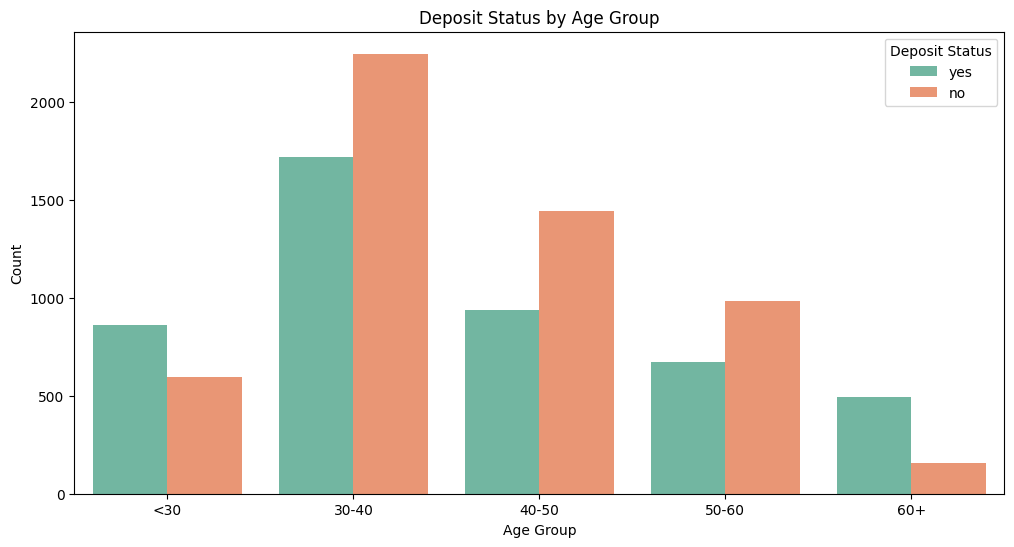

In [135]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения


# Create a new variable for age groups
age_bins = [0, 30, 40, 50, 60, 100]
age_labels = ['<30', '30-40', '40-50', '50-60', '60+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# Display the first few rows to verify the new variable
display(df[['age', 'age_group']].head())

# Plot a countplot to visualize the number of open/closed deposits for each age group
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='age_group', hue='deposit', palette='Set2')
plt.title('Deposit Status by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Deposit Status')
plt.show()

Deposit Counts by Age Group:


deposit,no,yes
age_group,,
<30,594,861
30-40,2245,1716
40-50,1444,938
50-60,984,670
60+,157,496



Deposit Ratios (yes/no) by Age Group:


,0
age_group,
<30,1.449495
30-40,0.764365
40-50,0.649584
50-60,0.680894
60+,3.159236


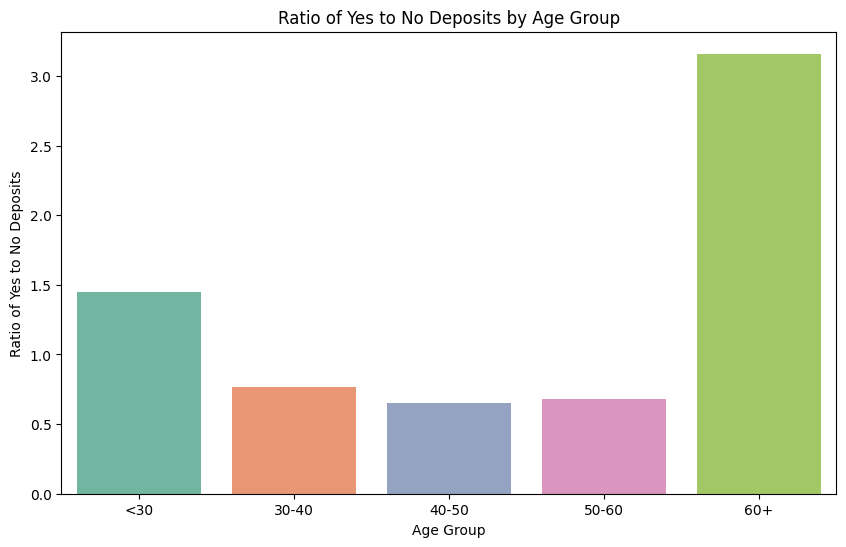

Age groups more likely to open a deposit: ['<30', '60+']


In [136]:

# Calculate the ratio of "yes" to "no" deposits for each age group
deposit_counts = df.groupby(['age_group', 'deposit']).size().unstack(fill_value=0)
deposit_ratios = (deposit_counts['yes'] / deposit_counts['no']).fillna(0)

# Display the deposit counts and ratios
print("Deposit Counts by Age Group:")
display(deposit_counts)
print("\nDeposit Ratios (yes/no) by Age Group:")
display(pd.DataFrame(deposit_ratios))

# Plot the ratios
plt.figure(figsize=(10, 6))
sns.barplot(x=deposit_ratios.index, y=deposit_ratios.values, palette='Set2')
plt.title('Ratio of Yes to No Deposits by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Ratio of Yes to No Deposits')
plt.show()

# Identify age groups more likely to open a deposit
more_likely_groups = deposit_ratios[deposit_ratios > 1].index.tolist()
print(f"Age groups more likely to open a deposit: {more_likely_groups}")

### Задания 9 и 10

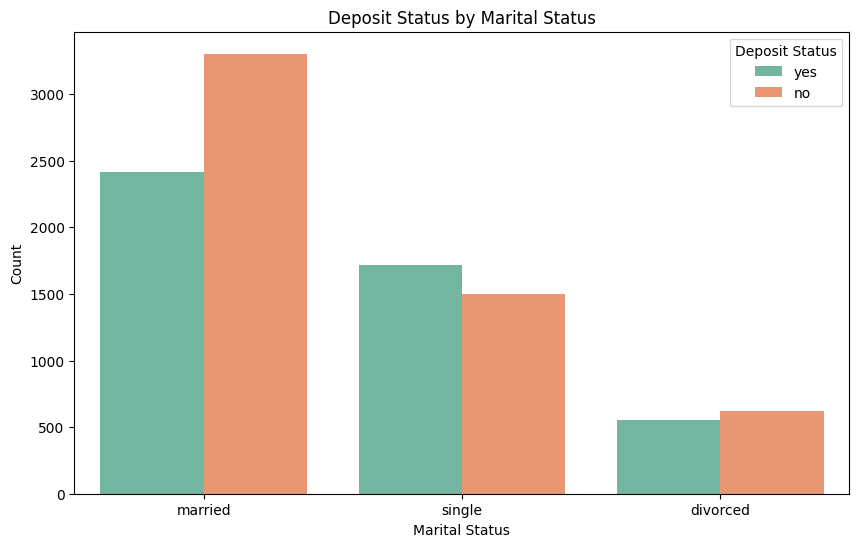

Deposit Counts by Marital Status:


deposit,no,yes
marital,,
divorced,624,553
married,3303,2412
single,1497,1716



Deposit Ratios (yes/no) by Marital Status:


,0
marital,
divorced,0.886218
married,0.730245
single,1.146293


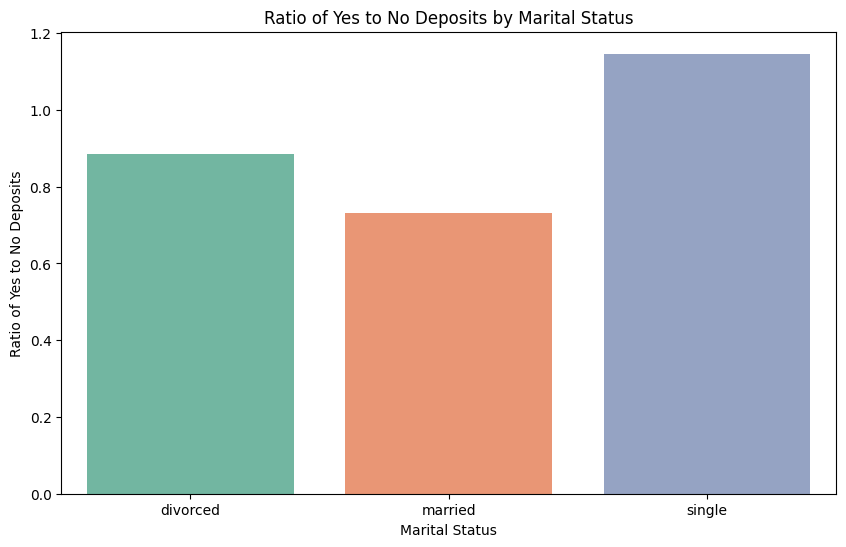

Marital status groups more likely to open a deposit: ['single']


In [137]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

# Create a count plot for Marital Status
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='marital', hue='deposit', palette='Set2')
plt.title('Deposit Status by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Deposit Status')
plt.show()

# Calculate the ratio of "yes" to "no" deposits for each marital status category
marital_deposit_counts = df.groupby(['marital', 'deposit']).size().unstack(fill_value=0)
marital_deposit_ratios = (marital_deposit_counts['yes'] / marital_deposit_counts['no']).fillna(0)

# Display the deposit counts and ratios
print("Deposit Counts by Marital Status:")
display(marital_deposit_counts)
print("\nDeposit Ratios (yes/no) by Marital Status:")
display(pd.DataFrame(marital_deposit_ratios))

# Plot the ratios
plt.figure(figsize=(10, 6))
sns.barplot(x=marital_deposit_ratios.index, y=marital_deposit_ratios.values, palette='Set2')
plt.title('Ratio of Yes to No Deposits by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Ratio of Yes to No Deposits')
plt.show()

# Identify marital status groups more likely to open a deposit
more_likely_marital_groups = marital_deposit_ratios[marital_deposit_ratios > 1].index.tolist()
print(f"Marital status groups more likely to open a deposit: {more_likely_marital_groups}")

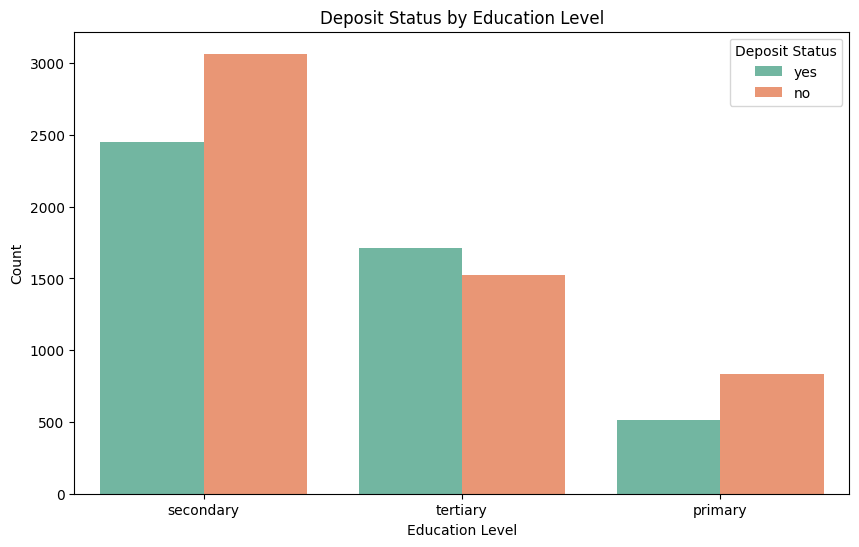

Deposit Counts by Education Level:


deposit,no,yes
education,,
primary,832,517
secondary,3066,2451
tertiary,1526,1713



Deposit Ratios (yes/no) by Education Level:


,0
education,
primary,0.621394
secondary,0.799413
tertiary,1.122543


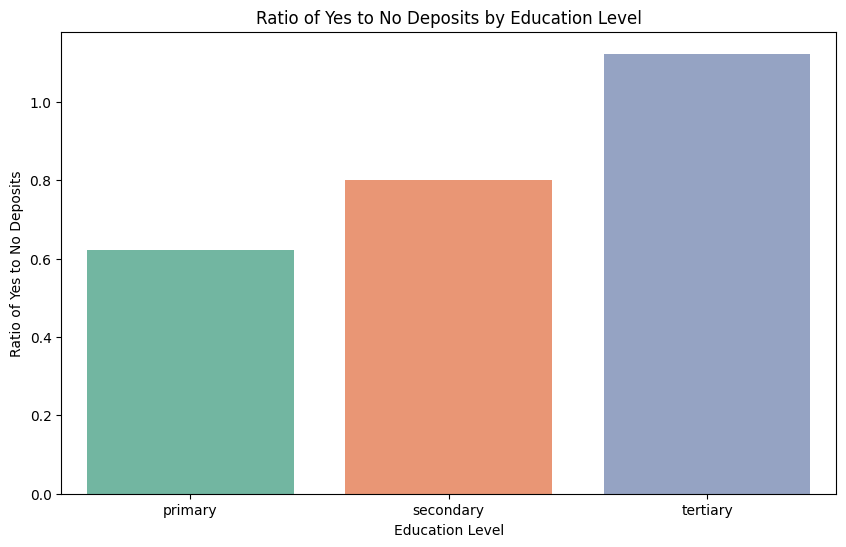

Education level groups more likely to open a deposit: ['tertiary']


In [138]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

# Create a count plot for Education
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='education', hue='deposit', palette='Set2')
plt.title('Deposit Status by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.legend(title='Deposit Status')
plt.show()

# Calculate the ratio of "yes" to "no" deposits for each education level category
education_deposit_counts = df.groupby(['education', 'deposit']).size().unstack(fill_value=0)
education_deposit_ratios = (education_deposit_counts['yes'] / education_deposit_counts['no']).fillna(0)

# Display the deposit counts and ratios
print("Deposit Counts by Education Level:")
display(education_deposit_counts)
print("\nDeposit Ratios (yes/no) by Education Level:")
display(pd.DataFrame(education_deposit_ratios))

# Plot the ratios
plt.figure(figsize=(10, 6))
sns.barplot(x=education_deposit_ratios.index, y=education_deposit_ratios.values, palette='Set2')
plt.title('Ratio of Yes to No Deposits by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Ratio of Yes to No Deposits')
plt.show()

# Identify education level groups more likely to open a deposit
more_likely_education_groups = education_deposit_ratios[education_deposit_ratios > 1].index.tolist()
print(f"Education level groups more likely to open a deposit: {more_likely_education_groups}")

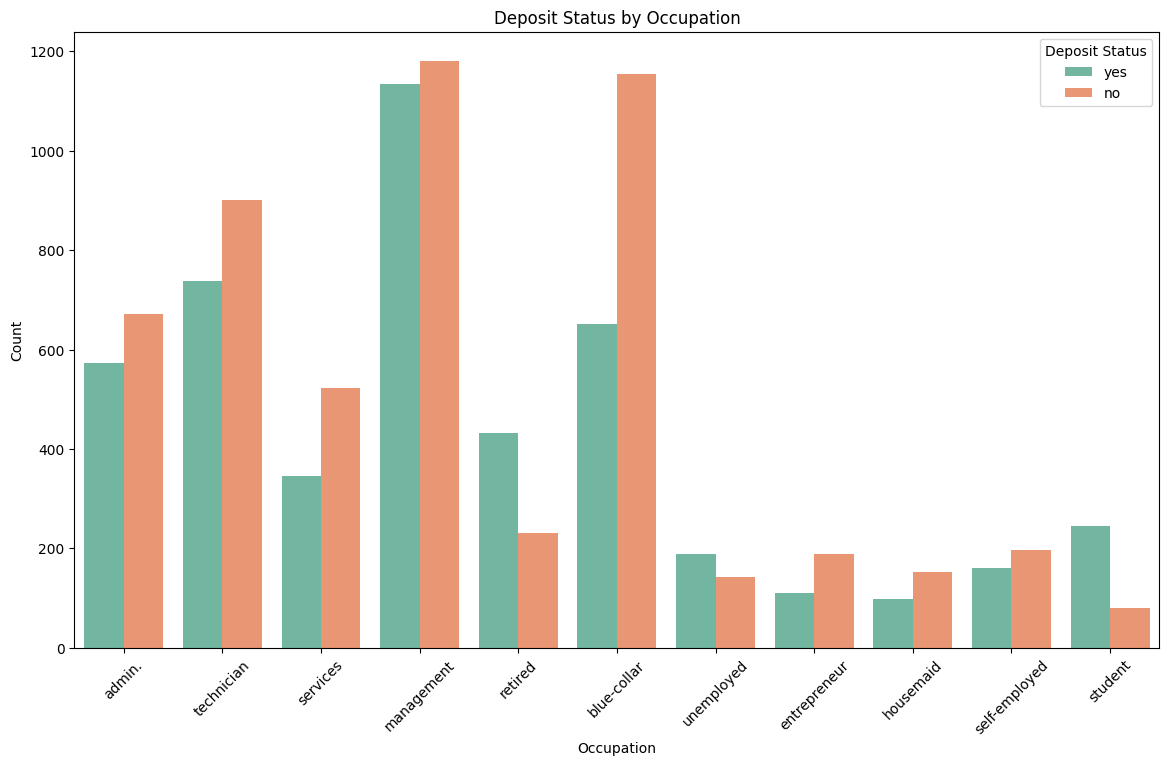

Deposit Counts by Occupation:


deposit,no,yes
job,,
admin.,672,574
blue-collar,1155,652
entrepreneur,189,111
housemaid,153,99
management,1180,1135
retired,231,432
self-employed,197,161
services,523,345
student,81,245



Deposit Ratios (yes/no) by Occupation:


,0
job,
admin.,0.854167
blue-collar,0.564502
entrepreneur,0.587302
housemaid,0.647059
management,0.961864
retired,1.870130
self-employed,0.817259
services,0.659656
student,3.024691


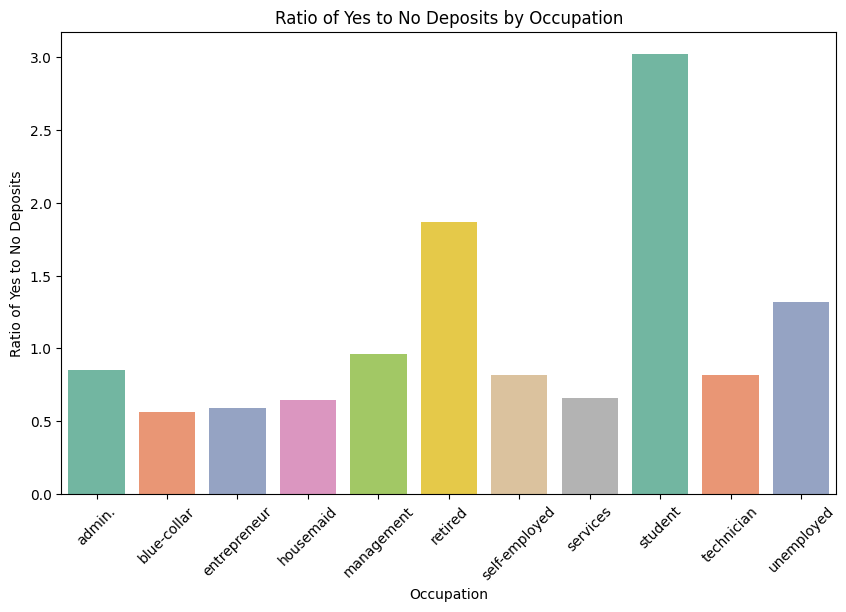

Occupation groups more likely to open a deposit: ['retired', 'student', 'unemployed']


In [139]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

# Create a count plot for Occupation
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='job', hue='deposit', palette='Set2')
plt.title('Deposit Status by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.legend(title='Deposit Status')
plt.xticks(rotation=45)
plt.show()

# Calculate the ratio of "yes" to "no" deposits for each occupation category
occupation_deposit_counts = df.groupby(['job', 'deposit']).size().unstack(fill_value=0)
occupation_deposit_ratios = (occupation_deposit_counts['yes'] / occupation_deposit_counts['no']).fillna(0)

# Display the deposit counts and ratios
print("Deposit Counts by Occupation:")
display(occupation_deposit_counts)
print("\nDeposit Ratios (yes/no) by Occupation:")
display(pd.DataFrame(occupation_deposit_ratios))

# Plot the ratios
plt.figure(figsize=(10, 6))
sns.barplot(x=occupation_deposit_ratios.index, y=occupation_deposit_ratios.values, palette='Set2')
plt.title('Ratio of Yes to No Deposits by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Ratio of Yes to No Deposits')
plt.xticks(rotation=45)
plt.show()

# Identify occupation groups more likely to open a deposit
more_likely_occupation_groups = occupation_deposit_ratios[occupation_deposit_ratios > 1].index.tolist()
print(f"Occupation groups more likely to open a deposit: {more_likely_occupation_groups}")

Occupation Counts:


job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64

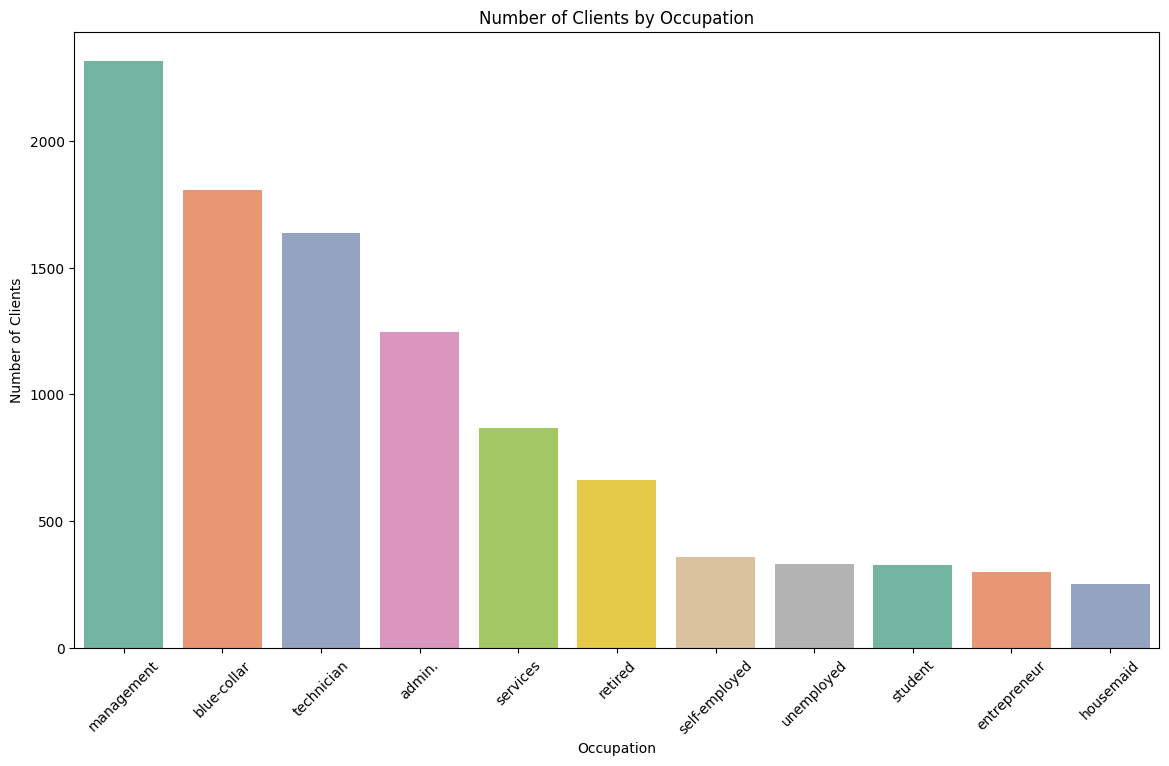

The occupation field with the largest number of clients is 'management' with 2315 clients.


In [140]:
# В какой сфере занято наибольшее число клиентов банка?

# Calculate the frequency of each occupation
occupation_counts = df['job'].value_counts()

# Display the occupation counts
print("Occupation Counts:")
display(occupation_counts)

# Plot the occupation counts
plt.figure(figsize=(14, 8))
sns.barplot(x=occupation_counts.index, y=occupation_counts.values, palette='Set2')
plt.title('Number of Clients by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Number of Clients')
plt.xticks(rotation=45)
plt.show()

# Identify the occupation field with the largest number of clients
largest_occupation = occupation_counts.idxmax()
largest_occupation_count = occupation_counts.max()

print(f"The occupation field with the largest number of clients is '{largest_occupation}' with {largest_occupation_count} clients.")

### Задание 11

Crosstab for those who have opened a deposit:


education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755



Crosstab for those who have not opened a deposit:


education,primary,secondary,tertiary
marital,,,
divorced,91,370,163
married,641,1830,832
single,100,866,531


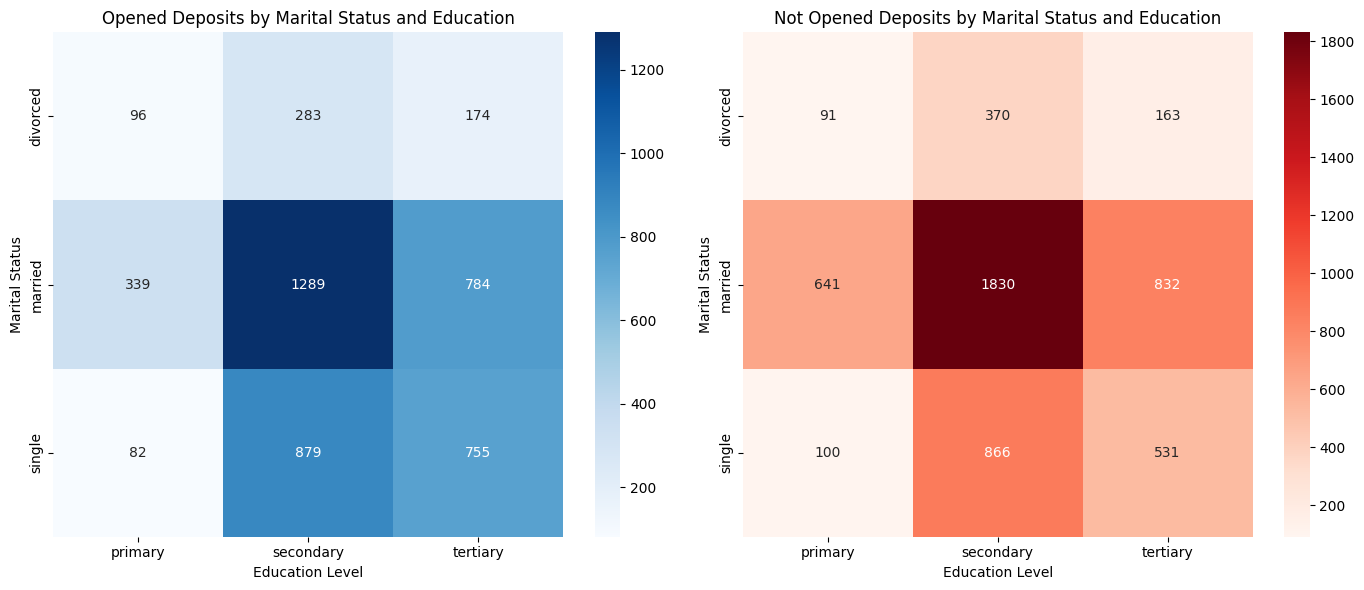

The most popular group for deposit holders is: ('married', 'secondary')
The most popular group for non-depositors is: ('married', 'secondary')
The most numerous intersection of categories is: ('married', 'secondary') with 3119 clients.


In [141]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

# Divide the dataset into two parts: those who have opened a deposit and those who have not
df_opened = df[df['deposit'] == 'yes']
df_not_opened = df[df['deposit'] == 'no']

# Create summary heatmaps for each part
opened_crosstab = pd.crosstab(df_opened['marital'], df_opened['education'])
not_opened_crosstab = pd.crosstab(df_not_opened['marital'], df_not_opened['education'])

# Display the crosstabs
print("Crosstab for those who have opened a deposit:")
display(opened_crosstab)
print("\nCrosstab for those who have not opened a deposit:")
display(not_opened_crosstab)

# Plot the heatmaps
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(opened_crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Opened Deposits by Marital Status and Education')
plt.xlabel('Education Level')
plt.ylabel('Marital Status')

plt.subplot(1, 2, 2)
sns.heatmap(not_opened_crosstab, annot=True, fmt='d', cmap='Reds')
plt.title('Not Opened Deposits by Marital Status and Education')
plt.xlabel('Education Level')
plt.ylabel('Marital Status')

plt.tight_layout()
plt.show()

# Determine the most popular groups for deposit holders and non-depositors
most_popular_opened = opened_crosstab.stack().idxmax()
most_popular_not_opened = not_opened_crosstab.stack().idxmax()

print(f"The most popular group for deposit holders is: {most_popular_opened}")
print(f"The most popular group for non-depositors is: {most_popular_not_opened}")

# Determine the most numerous intersection of categories in the whole dataset
total_crosstab = pd.crosstab(df['marital'], df['education'])
most_numerous_intersection = total_crosstab.stack().idxmax()
most_numerous_intersection_count = total_crosstab.stack().max()

print(f"The most numerous intersection of categories is: {most_numerous_intersection} with {most_numerous_intersection_count} clients.")

## Часть 3: преобразование данных

### Задание 1

In [142]:
# преобразуйте уровни образования

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'education' feature
df['education_encoded'] = label_encoder.fit_transform(df['education'])

# Display the unique values of the original and encoded 'education' feature
print("Original 'education' values:")
print(df['education'].unique())
print("\nEncoded 'education' values:")
print(df['education_encoded'].unique())

# Calculate the sum of the encoded 'education' values
education_encoded_sum = df['education_encoded'].sum()
print(f"\nSum of the encoded 'education' values: {education_encoded_sum}")

# Display the first few rows to verify the encoding
display(df[['education', 'education_encoded']].head())

Original 'education' values:
['secondary' 'tertiary' 'primary']

Encoded 'education' values:
[1 2 0]

Sum of the encoded 'education' values: 11995


,education,education_encoded
0,secondary,1
1,secondary,1
2,secondary,1
3,secondary,1
4,tertiary,2


### Задания 2 и 3

In [143]:
# преобразуйте бинарные переменные в представление из нулей и единиц

# Encode the 'age_group' feature
df['age_group_encoded'] = label_encoder.fit_transform(df['age_group'])

# Recode the 'deposit' variable to binary
df['deposit_binary'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

# Calculate the standard deviation of the converted target variable 'deposit_binary'
deposit_binary_std = df['deposit_binary'].std()
################################
print(f"The standard deviation of the 'deposit_binary' variable is: {deposit_binary_std:.3f}")

################################################################
# Recode the other binary variables
binary_variables = ['default', 'housing', 'loan']
for var in binary_variables:
    df[f'{var}_binary'] = df[var].apply(lambda x: 1 if x == 'yes' else 0)
    
# Calculate the arithmetic mean for each binary variable
default_binary_mean = df['default_binary'].mean()
housing_binary_mean = df['housing_binary'].mean()
loan_binary_mean = df['loan_binary'].mean()

# Sum the means and round to three digits after the separator
total_mean = round(default_binary_mean + housing_binary_mean + loan_binary_mean, 3)

# Print the arithmetic means and the rounded total
# print(f"The arithmetic mean of the 'default_binary' variable is: {default_binary_mean:.4f}")
# print(f"The arithmetic mean of the 'housing_binary' variable is: {housing_binary_mean:.4f}")
# print(f"The arithmetic mean of the 'loan_binary' variable is: {loan_binary_mean:.4f}")
print(f"The rounded sum of the arithmetic means is: {total_mean:.3f}")

################################

# Display the unique values of the original and encoded features
print("\nOriginal 'education' values:")
print(df['education'].unique())
print("\nEncoded 'education' values:")
print(df['education_encoded'].unique())

print("\nOriginal 'age_group' values:")
print(df['age_group'].unique())
print("\nEncoded 'age_group' values:")
print(df['age_group_encoded'].unique())

# Calculate the sum of the encoded 'education' and 'age_group' values
education_encoded_sum = df['education_encoded'].sum()
age_group_encoded_sum = df['age_group_encoded'].sum()
print(f"\nSum of the encoded 'education' values: {education_encoded_sum}")
print(f"Sum of the encoded 'age_group' values: {age_group_encoded_sum}")

# Display the first few rows to verify the encoding and recoding
display(df[['education', 'education_encoded', 'age_group', 'age_group_encoded', 'deposit', 'deposit_binary']].head())

The standard deviation of the 'deposit_binary' variable is: 0.499
The rounded sum of the arithmetic means is: 0.635

Original 'education' values:
['secondary' 'tertiary' 'primary']

Encoded 'education' values:
[1 2 0]

Original 'age_group' values:
['50-60', '40-50', '60+', '30-40', '<30']
Categories (5, object): ['<30' < '30-40' < '40-50' < '50-60' < '60+']

Encoded 'age_group' values:
[2 1 3 0 4]

Sum of the encoded 'education' values: 11995
Sum of the encoded 'age_group' values: 13469


,education,education_encoded,age_group,age_group_encoded,deposit,deposit_binary
0,secondary,1,50-60,2,yes,1
1,secondary,1,50-60,2,yes,1
2,secondary,1,40-50,1,yes,1
3,secondary,1,50-60,2,yes,1
4,tertiary,2,50-60,2,yes,1


### Задание 4

In [144]:
# создайте дамми-переменные

# Enumerate the specific categorical variables to create dummy variables for
categorical_columns = ['job', 'marital', 'contact', 'month', 'poutcome']

# Create dummy variables for the specified categorical columns
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Count the number of features excluding the target variable 'deposit_binary'
num_features = df.drop(columns=['deposit_binary']).shape[1]

# Print the number of features
print(f"The number of features in the dataset now, excluding the target variable, is: {num_features}")

# Display the first few rows to verify the dummy variable creation
display(df.head())

# Display the updated columns to verify the inclusion of dummy variables
print("Updated columns in the dataset:")
print(df.columns)

The number of features in the dataset now, excluding the target variable, is: 46


,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,59,secondary,no,2343.0,yes,no,5,1042,1,-1,...,False,False,False,True,False,False,False,False,False,True
1,56,secondary,no,45.0,no,no,5,1467,1,-1,...,False,False,False,True,False,False,False,False,False,True
2,41,secondary,no,1270.0,yes,no,5,1389,1,-1,...,False,False,False,True,False,False,False,False,False,True
3,55,secondary,no,2476.0,yes,no,5,579,1,-1,...,False,False,False,True,False,False,False,False,False,True
4,54,tertiary,no,184.0,no,no,5,673,2,-1,...,False,False,False,True,False,False,False,False,False,True


Updated columns in the dataset:
Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'deposit', 'age_group',
       'education_encoded', 'age_group_encoded', 'deposit_binary',
       'default_binary', 'housing_binary', 'loan_binary', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_married', 'marital_single',
       'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')


### Задания 5 и 6

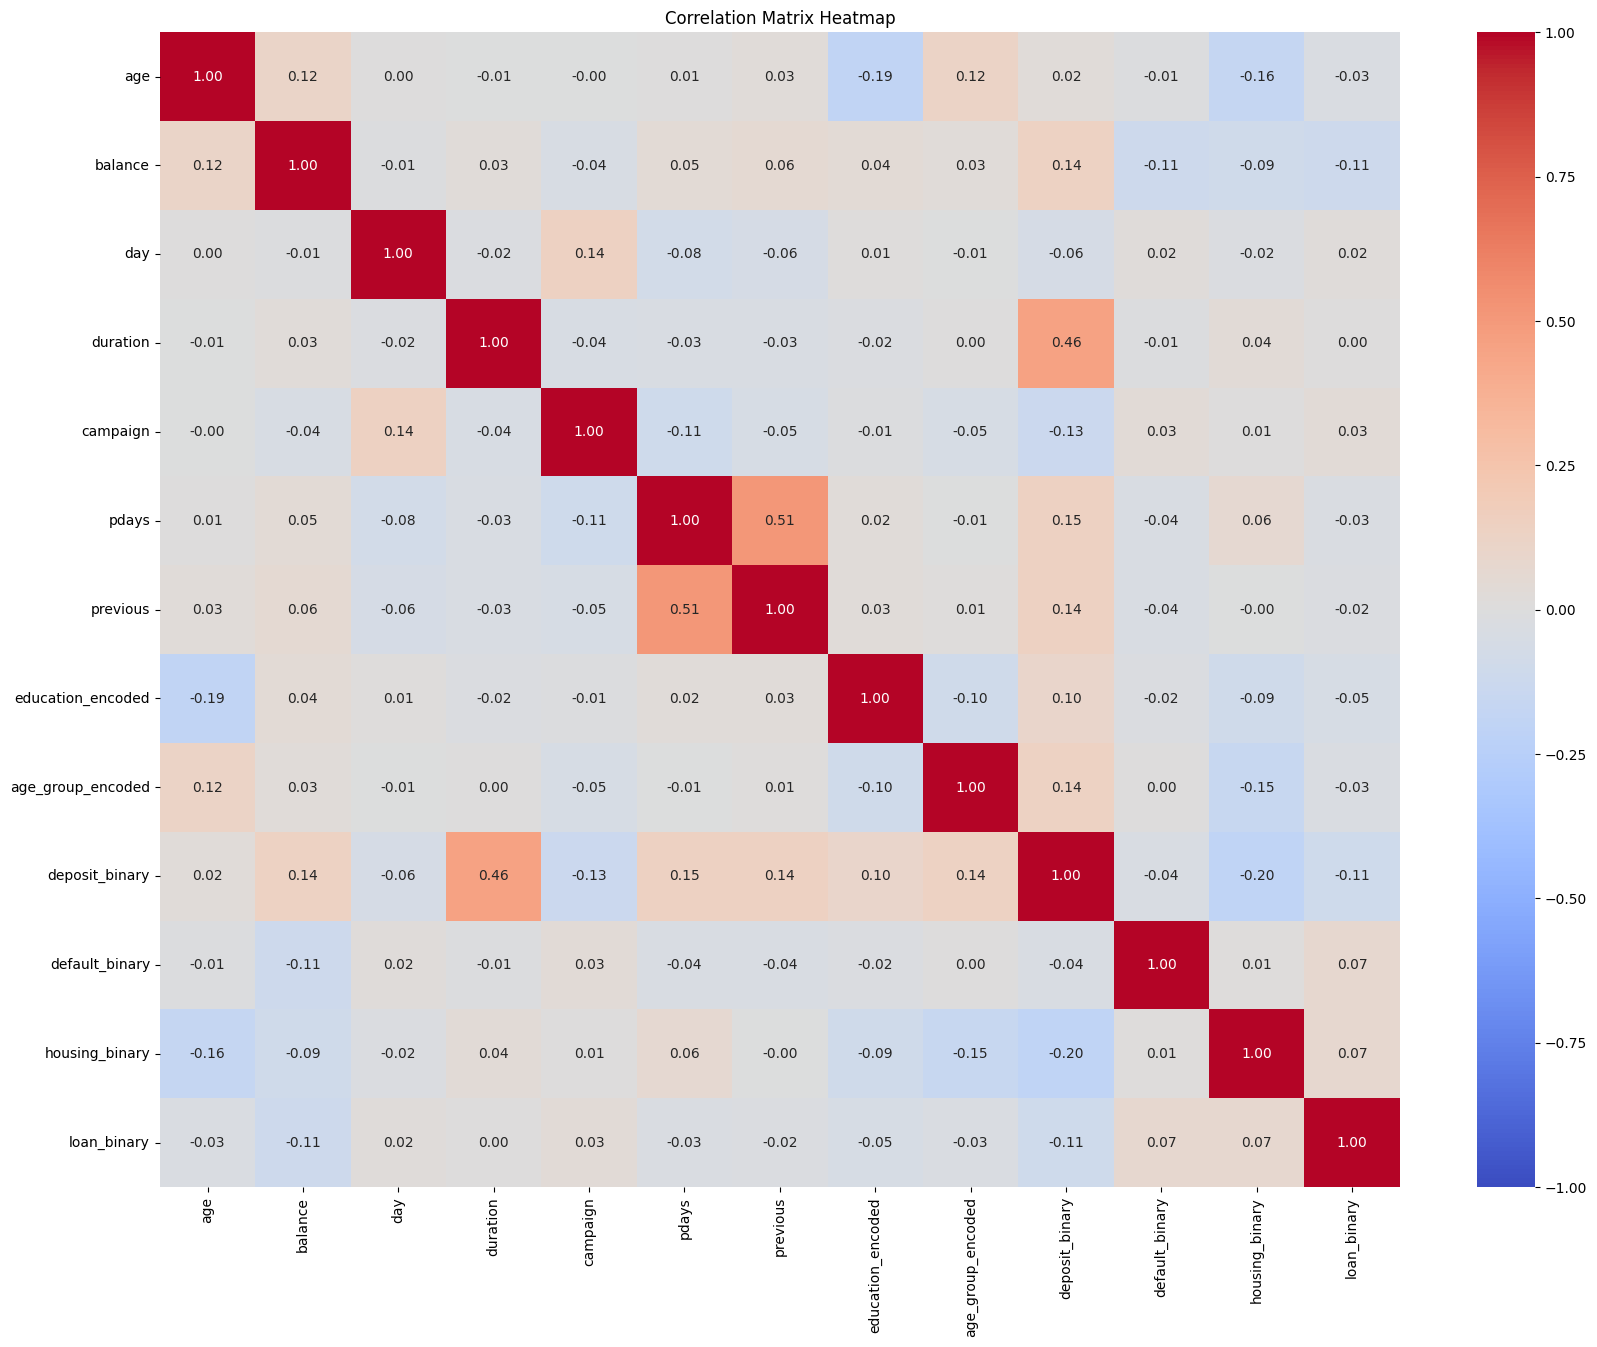

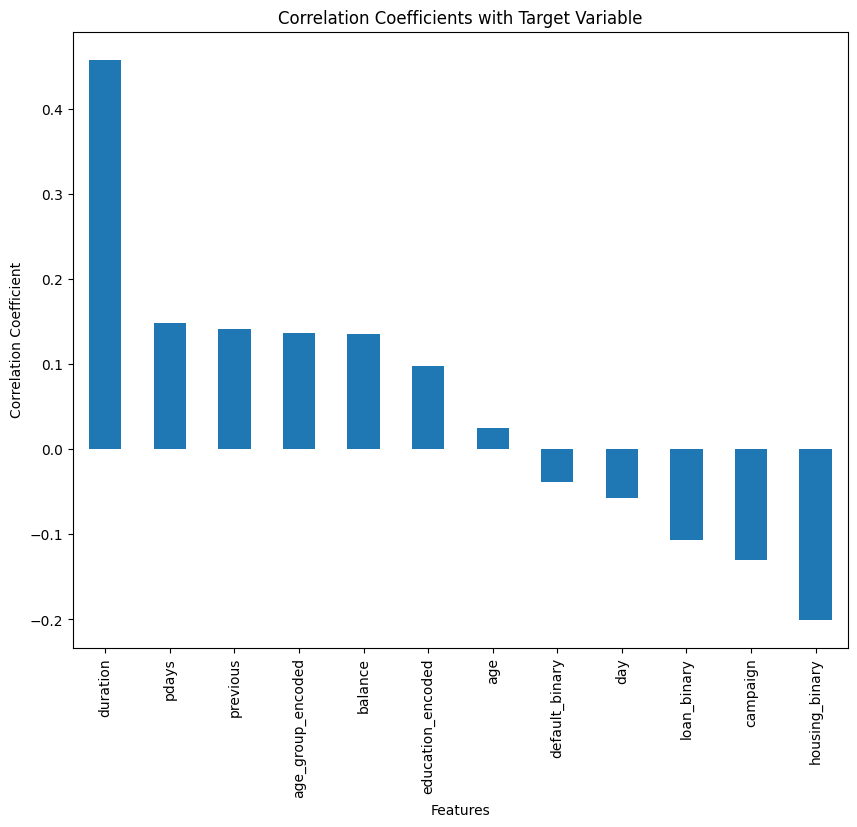

Correlation Coefficients with the target variable 'deposit_binary':
duration             0.457818
pdays                0.147917
previous             0.141102
age_group_encoded    0.136243
balance              0.135893
education_encoded    0.098253
age                  0.024357
default_binary      -0.038872
day                 -0.056878
loan_binary         -0.107240
campaign            -0.130707
housing_binary      -0.200290
Name: deposit_binary, dtype: float64


In [145]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

# Select only numeric features for the correlation matrix
numeric_features = df.select_dtypes(include=['number'])

# Build the correlation matrix
corr_matrix = numeric_features.corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Extract correlation coefficients with the target variable 'deposit_binary'
correlation_with_target = corr_matrix['deposit_binary'].drop('deposit_binary').sort_values(ascending=False)

# Plot the correlation coefficients with the target variable
plt.figure(figsize=(10, 8))
correlation_with_target.plot(kind='bar')
plt.title('Correlation Coefficients with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()

# Display the correlation coefficients with the target variable
print("Correlation Coefficients with the target variable 'deposit_binary':")
print(correlation_with_target)

### Задания 7 и 8

In [146]:
# Define the target variable and predictors
X = df.drop(columns=['deposit', 'deposit_binary', 'education', 'age_group', 'default', 'housing', 'loan'])
y = df['deposit_binary']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6770, 40)
X_test shape: (3335, 40)
y_train shape: (6770,)
y_test shape: (3335,)


In [147]:
# рассчитайте необходимые показатели

# Calculate the average value of the target variable in the test sample
average_value = y_test.mean()
print(f"The average value of the target variable in the test sample is: {average_value:.2f}")

The average value of the target variable in the test sample is: 0.46


### Задание 9

In [148]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

# Apply SelectKBest to select the top 15 features
selector = SelectKBest(score_func=f_classif, k=15)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get the selected feature names
selected_features = X.columns[selector.get_support()]

# Print the selected feature names
print("Selected features:")
print(selected_features)

# Display the shapes of the resulting datasets
print("X_train_selected shape:", X_train_selected.shape)
print("X_test_selected shape:", X_test_selected.shape)

Selected features:
Index(['balance', 'duration', 'campaign', 'pdays', 'previous',
       'age_group_encoded', 'housing_binary', 'loan_binary', 'contact_unknown',
       'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')
X_train_selected shape: (6770, 15)
X_test_selected shape: (3335, 15)


In [149]:
# Check if there is any variable that is not in the specified list
specified_list = ['month_mar', 'month_may', 'month_oct', 'month_sep', 'month_jan']
missing_features = [feature for feature in specified_list if feature not in selected_features]
print("Variable not in the list:")
print(missing_features)

Variable not in the list:
['month_jan']


### Задание 10

In [150]:
# нормализуйте данные с помощью minmaxsxaler

from sklearn.preprocessing import MinMaxScaler

# Normalize the predictors using Min-Max normalization
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_normalized = scaler.fit_transform(X_train_selected)
X_test_normalized = scaler.transform(X_test_selected)

# Convert the normalized arrays back to DataFrames for easier inspection
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=selected_features)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=selected_features)

# Display the shapes of the resulting datasets
print("X_train_normalized shape:", X_train_normalized_df.shape)
print("X_test_normalized shape:", X_test_normalized_df.shape)

# Display the first few rows of the normalized training data
print("First few rows of the normalized training data:")
display(X_train_normalized_df.head())

# Calculate the arithmetic mean for the first predictor in the test sample
first_predictor_mean = X_test_normalized[:, 0].mean()
first_predictor_mean_rounded = round(first_predictor_mean, 2)
print(f"The arithmetic mean for the first predictor in the test sample is: {first_predictor_mean_rounded}")

X_train_normalized shape: (6770, 15)
X_test_normalized shape: (3335, 15)
First few rows of the normalized training data:


,balance,duration,campaign,pdays,previous,age_group_encoded,housing_binary,loan_binary,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
0,0.426374,0.131735,0.00000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.346531,0.075793,0.00000,0.240936,0.034483,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.335242,0.102346,0.02381,0.419883,0.086207,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.407886,0.034803,0.00000,0.120468,0.086207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.571499,0.025264,0.00000,0.138012,0.137931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


The arithmetic mean for the first predictor in the test sample is: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [151]:
# обучите логистическую регрессию и рассчитайте метрики качества

from sklearn.linear_model import LogisticRegression

# Implement logistic regression
log_reg = LogisticRegression(solver='sag', random_state=42, max_iter=1000)

# Train the model
log_reg.fit(X_train_normalized, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test_normalized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy of Logistic Regression in test split: {accuracy:.2f}")
print("Classification Report in test split:")
print(report)

Accuracy of Logistic Regression in test split: 0.81
Classification Report in test split:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

In [152]:
# обучите решающие деревья, настройте максимальную глубину

from sklearn.tree import DecisionTreeClassifier

# Implement decision tree classifier
dec_tree = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Train the decision tree model
dec_tree.fit(X_train_normalized, y_train)

# Make predictions on the train set using the decision tree
y_pred_train_dec_tree = dec_tree.predict(X_train_normalized)
# Make predictions on the test set using the decision tree
y_pred_test_dec_tree = dec_tree.predict(X_test_normalized)

# Evaluate the decision tree model on train split
accuracy_train_dec_tree = accuracy_score(y_train, y_pred_train_dec_tree)
report_train_dec_tree = classification_report(y_train, y_pred_train_dec_tree)
# Evaluate the decision tree model on test split
accuracy_test_dec_tree = accuracy_score(y_test, y_pred_test_dec_tree)
report_test_dec_tree = classification_report(y_test, y_pred_test_dec_tree)

# Display the decision tree results accuracy on train split and on test split
print(f"Accuracy of Decision Tree: {accuracy_train_dec_tree:.2f}")
print(f"Accuracy of Decision Tree: {accuracy_test_dec_tree:.2f}")

# Display the decision tree report on train split and on the test split

print("Classification Report for Decision Tree on train split:")
print(report_train_dec_tree)

print("Classification Report for Decision Tree on the test split:")
print(report_test_dec_tree)

Accuracy of Decision Tree: 1.00
Accuracy of Decision Tree: 0.74
Classification Report for Decision Tree on train split:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

Classification Report for Decision Tree on the test split:
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      1790
           1       0.72      0.71      0.72      1545

    accuracy                           0.74      3335
   macro avg       0.74      0.74      0.74      3335
weighted avg       0.74      0.74      0.74      3335



Maximum depth vs. Train accuracy:


[(1, 0.712),
 (2, 0.729),
 (3, 0.776),
 (4, 0.776),
 (5, 0.804),
 (6, 0.819),
 (7, 0.836),
 (8, 0.842),
 (9, 0.853),
 (10, 0.866),
 (11, 0.879),
 (12, 0.889),
 (13, 0.901),
 (14, 0.912),
 (15, 0.922),
 (16, 0.931),
 (17, 0.942),
 (18, 0.951),
 (19, 0.959),
 (20, 0.966)]

Maximum depth vs. Test accuracy:


[(1, 0.706),
 (2, 0.718),
 (3, 0.77),
 (4, 0.77),
 (5, 0.794),
 (6, 0.809),
 (7, 0.819),
 (8, 0.812),
 (9, 0.813),
 (10, 0.803),
 (11, 0.796),
 (12, 0.788),
 (13, 0.783),
 (14, 0.788),
 (15, 0.784),
 (16, 0.781),
 (17, 0.772),
 (18, 0.769),
 (19, 0.76),
 (20, 0.756)]

Best depth: 7


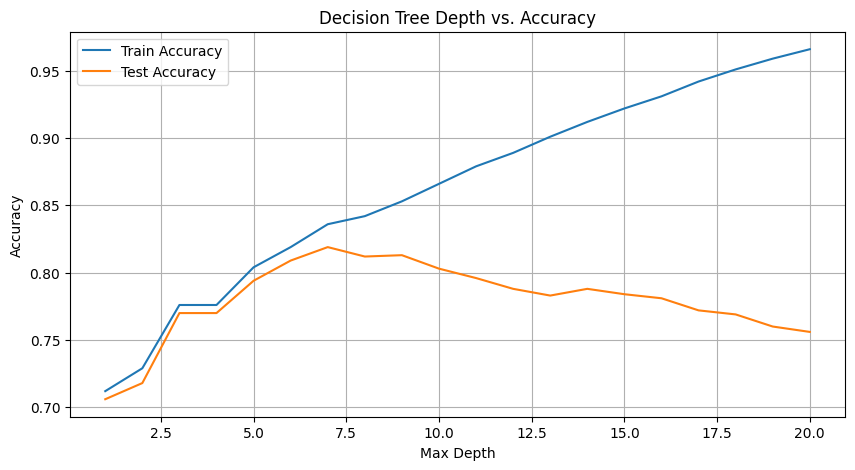

In [153]:
# Search for different maximum tree depths
train_accuracies = []
test_accuracies = []
max_depths = range(1, 21)  # Optionally. We can adjust the range as needed

for depth in max_depths:
    # Implement decision tree classifier with current depth
    dec_tree = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=depth)
    
    # Train the decision tree model
    dec_tree.fit(X_train_normalized, y_train)
    
    # Evaluate the model on training data
    y_train_pred = dec_tree.predict(X_train_normalized)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)
    
    # Evaluate the model on test data
    y_test_pred = dec_tree.predict(X_test_normalized)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Round the accuracies to 3 places after delimeter
train_accuracies = [round(acc, 3) for acc in train_accuracies]
test_accuracies = [round(acc, 3) for acc in test_accuracies]

# Find the depth with maximum test accuracy without overfitting
best_depth = max_depths[test_accuracies.index(max(test_accuracies))]

# Print the results
print("Maximum depth vs. Train accuracy:")
display(list(zip(max_depths, train_accuracies)))
print("Maximum depth vs. Test accuracy:")
display(list(zip(max_depths, test_accuracies)))
print(f"Best depth: {best_depth}")

# Plot the accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(max_depths, train_accuracies, label='Train Accuracy')
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Depth vs. Accuracy')
plt.legend()
plt.grid()
plt.show()

### Задание 5

In [154]:
# подберите оптимальные параметры с помощью gridsearch

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

# Implement the decision tree classifier
dec_tree = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Implement GridSearchCV with f1-score as the metric
grid_search = GridSearchCV(estimator=dec_tree, param_grid=param_grid, cv=5, scoring='f1')

# Train the model using GridSearchCV
grid_search.fit(X_train_normalized, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# # Evaluate the best model on the test set
# best_model = grid_search.best_estimator_
# y_test_pred = best_model.predict(X_test_normalized)
# test_accuracy = accuracy_score(y_test, y_test_pred)
# classification_rep = classification_report(y_test, y_test_pred)

# Print the results
print(f"Best parameters: {best_params}")
print(f"Best cross-validation f1-score: {best_score:.2f}")
# print(f"Test set accuracy: {test_accuracy:.3f}")
# print("Classification Report for Test Set:")
# print(classification_rep)

Best parameters: {'max_depth': 7, 'min_samples_split': 7}
Best cross-validation f1-score: 0.79


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [155]:
# обучите на ваших данных случайный лес

# Train a random forest classifier with the specified parameters
random_forest = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

# Train the model
random_forest.fit(X_train_normalized, y_train)

# Make predictions on the test set
y_test_pred = random_forest.predict(X_test_normalized)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
classification_rep = classification_report(y_test, y_test_pred)

# Print the results
print(f"Test set accuracy: {test_accuracy:.2f}")
print(f"Test set recall: {test_recall:.2f}")
print("Classification Report for Test Set:")
print(classification_rep)

Test set accuracy: 0.83
Test set recall: 0.83
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.81      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [156]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

# Train a gradient boosting classifier with the specified parameters
gradient_boosting = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

# Train the model
gradient_boosting.fit(X_train_normalized, y_train)

# Make predictions on the test set
y_test_pred = gradient_boosting.predict(X_test_normalized)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

# Print the results
print(f"Test set accuracy: {test_accuracy:.2f}")
print(f"Test set recall: {test_recall:.2f}")
print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

Test set accuracy: 0.83
Test set recall: 0.83
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.81      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [157]:
# объедините уже известные вам алгоритмы с помощью стекинга 

# Define the base models with the parameters used in previous tasks
decision_tree = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=7, min_samples_split=7)
logistic_regression = LogisticRegression(solver='sag', max_iter=1000, random_state=42)
gradient_boosting = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42)

# Define the meta-model
meta_model = LogisticRegression(solver='sag', max_iter=1000, random_state=42)

# Create the StackingClassifier
stacking_model = StackingClassifier(
    estimators=[
        ('decision_tree', decision_tree),
        ('logistic_regression', logistic_regression),
        ('gradient_boosting', gradient_boosting)
    ],
    final_estimator=meta_model,
    cv=5
)

# Train the stacking model
stacking_model.fit(X_train_normalized, y_train)

display(stacking_model)

# Make predictions on the test set
y_test_pred = stacking_model.predict(X_test_normalized)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)

# Print the results
print(f"Test set accuracy: {test_accuracy:.2f}")
print(f"Test set recall: {test_recall:.2f}")
print(f"Test set precision: {test_precision:.2f}")
print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

StackingClassifier(cv=5,
                   estimators=[('decision_tree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       min_samples_split=7,
                                                       random_state=42)),
                               ('logistic_regression',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('gradient_boosting',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42,
                                                      solver='sag'))

Test set accuracy: 0.82
Test set recall: 0.81
Test set precision: 0.81
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [158]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

gradient_boosting.fit(X_train_normalized, y_train)

# Extract feature importances
feature_importances = gradient_boosting.feature_importances_

# Get feature names
feature_names = X.columns[selector.get_support()]

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Get the top 3 features
top_3_features = feature_importance_df.head(3)

# Display the top 3 features
print(top_3_features)

             Feature  Importance
1           duration    0.499427
13  poutcome_success    0.116497
8    contact_unknown    0.076628


### Задания 6,7,8

In [159]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Create the RandomForestClassifier with the trial's hyperparameters
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Perform cross-validation
    scores = cross_val_score(rf, X_train_normalized, y_train, cv=5, scoring='accuracy')
    return scores.mean()

# Create the study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Train the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_normalized, y_train)

# Make predictions on the test set
y_test_pred = best_rf.predict(X_test_normalized)

# Evaluate the final model
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test set accuracy: {test_accuracy:.2f}")
print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

[I 2024-05-30 22:13:59,383] A new study created in memory with name: no-name-7c95efa8-e8eb-472f-9746-a05448264163
[I 2024-05-30 22:14:01,164] Trial 0 finished with value: 0.8335302806499261 and parameters: {'n_estimators': 136, 'max_depth': 21, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8335302806499261.
[I 2024-05-30 22:14:03,170] Trial 1 finished with value: 0.8317577548005909 and parameters: {'n_estimators': 163, 'max_depth': 23, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8335302806499261.
[I 2024-05-30 22:14:05,345] Trial 2 finished with value: 0.8367799113737074 and parameters: {'n_estimators': 147, 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8367799113737074.
[I 2024-05-30 22:14:07,056] Trial 3 finished with value: 0.8350073855243723 and parameters: {'n_estimators': 138, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8367799113737074.
[I 2024-05-30 22:14:09,595] Trial 4 finished with value: 0.83426883308714

Best hyperparameters: {'n_estimators': 127, 'max_depth': 21, 'min_samples_leaf': 3}
Test set accuracy: 0.83
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [160]:
# save the best model's accuracy and classification report for later use
best_rf_accuracy = test_accuracy
best_rf_classification_report = classification_report(y_test, y_test_pred)

# **Дополнительные задания**

## 1. Новый подход для поиска аномальных значений в данных

###  z-score

In [155]:
# define the function to visualize distribution after removing outliers
def visualize_distribution(method, df_primary, df_cleaned,  column, mean_value, lower_bound, upper_bound):
    plt.figure(figsize=(8, 4))
    sns.histplot(df_primary[column], bins=50, kde=True, color='lightgrey')
    sns.histplot(df_cleaned[column], bins=50, kde=True, color='gold')
    plt.axvline(mean_value, color='g', linestyle='dashed', linewidth=1, label='Mean')
    plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=1, label='Lower Bound')
    plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=1, label='Upper Bound')
    plt.title(f'Distribution of {column} with {method}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [123]:
# define the function to proceed outliers by z-score method
def f_outliers_z_score(data, feature, log_scale=False):
    # if log_scale:
    #     x = np.log(data[feature]+1)
    # else:
    #     x = data[feature]
    x=data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned,  mu, sigma, lower_bound, upper_bound


### DBSCAN

In [144]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [150]:
# define the function to proceed outliers with DBSCAN
def f_dbscan(df, column, eps=0.5, min_samples=5):
    # Standardize the feature
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[[column]])

    # Apply DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(scaled_data)
    
    # Identify outliers
    outliers_dbscan = df[labels == -1]
    remaining_data = df[labels != -1]
    
    # return outliers, remaining_data, labels, scaler

    unique_labels = set(labels)
    bounds = {}
    
    for label in unique_labels:
        if label != -1:
            cluster_data = df[labels == label][column]
            original_cluster_data = scaler.inverse_transform(cluster_data.values.reshape(-1, 1)).flatten()
            lower_bound_dbscan = np.min(original_cluster_data)
            upper_bound_dbscan = np.max(original_cluster_data)
            bounds[label] = (lower_bound_dbscan, upper_bound_dbscan)
    
    return outliers_dbscan, remaining_data, labels, bounds

In [158]:
def visualize_dbscan_results(df, column, labels, bounds):
    plt.figure(figsize=(8, 4))
    # plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=50, kde=True)
    unique_labels = set(labels)
    colors = ['r' if label == -1 else 'b' for label in labels]
    plt.scatter(df[column], np.zeros_like(df[column]), c=colors, marker='|')
    for label, (lower_bound, upper_bound) in bounds.items():
        plt.axvline(lower_bound, color='g', linestyle='dashed', linewidth=1, label=f'Cluster {label} Lower Bound')
        plt.axvline(upper_bound, color='b', linestyle='dashed', linewidth=1, label=f'Cluster {label} Upper Bound')
    plt.title(f'DBSCAN Outlier Detection on {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

### Обработка и сравнение результатов

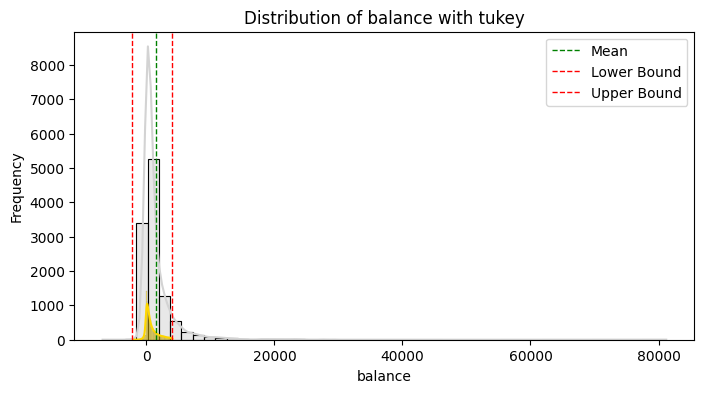

Average: 1529.13
Bounds of 1,5 IQR for separating outliers: (-2241.00, 4063.00)
Outliers number: 1057
Remaining objects: 10105


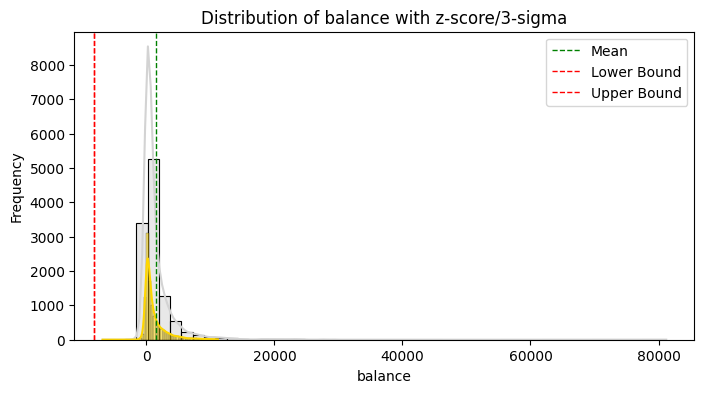

Average: 1526.94
3-sigma confidential interval: (-8147.55, 11201.43)
Outliers number: 173
Remaining objects: 10989


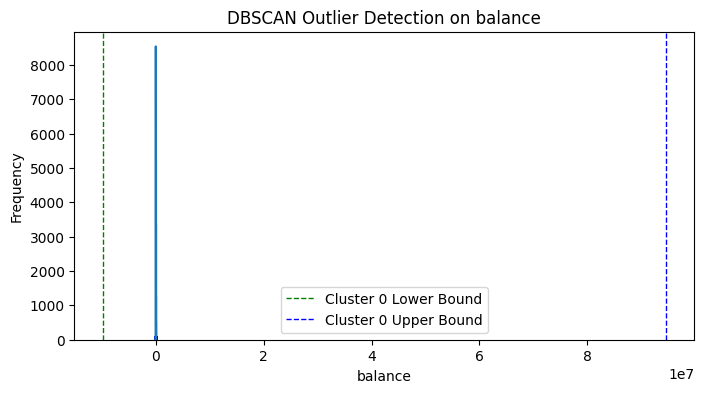

Outliers number (DBSCAN): 17
Remaining entities (DBSCAN): 11145
Bounds for clusters: {0: (-9859560.504319012, 94613791.65150946)}


In [160]:
# Visualization of the distribution after removing outliers with tukey bounds for comparation with another metods 
visualize_distribution(
    'tukey',
    df_save,
    remaining_objects_tukey,
    'balance',
    average_balance,
    lower_bound_tukey,
    upper_bound_tukey
    )

# Print the results of the tukey method
print(f"Average: {average_balance:.2f}")
print(f"Bounds of 1,5 IQR for separating outliers: ({lower_bound_tukey:.2f}, {upper_bound_tukey:.2f})")
print(f"Outliers number: {outliers_tukey.shape[0]}")
print(f"Remaining objects: {remaining_objects_tukey.shape[0]}")

# Implement the z-score method 
outliers_zscore, df_remaining_objects_zscore, mean_value_zscore, std_value, lower_bound_zscore, upper_bound_zscore = f_outliers_z_score(
    df_save,
    'balance'
    )

# Visualize the distribution after removing outliers with 3-sigma/z-score bounds
visualize_distribution(
    'z-score/3-sigma',
    df_save,
    df_remaining_objects_zscore,
    'balance',
    mean_value_zscore,
    lower_bound_zscore,
    lower_bound_zscore
    )

# Print the results of the z-score method
print(f"Average: {mean_value_zscore:.2f}")
print(f"3-sigma confidential interval: ({lower_bound_zscore:.2f}, {upper_bound_zscore:.2f})")
print(f"Outliers number: {outliers_zscore.shape[0]}")
print(f"Remaining objects: {df_remaining_objects_zscore.shape[0]}")

# Apply DBSCAN to the 'balance' column
outliers_dbscan, remaining_data_dbscan, labels_dbscan, bounds_dbscan = f_dbscan(df_save, 'balance', eps=0.5, min_samples=5)

# Visualize the DBSCAN results
visualize_dbscan_results(df_save, 'balance', labels_dbscan, bounds_dbscan)

# Print the results
print(f"Outliers number (DBSCAN): {outliers_dbscan.shape[0]}")
print(f"Remaining entities (DBSCAN): {remaining_data_dbscan.shape[0]}")
print(f"Bounds for clusters: {bounds_dbscan}")

По текущим результатам можем сравнить результаты обработки выбросов трех методов: метод интерквантильного размаха (он же метод Тьюки), метод z-score/3-х сигм и DBSCAN (метод путем кластеризации).

> Было проведено сравнение результатов обработки выбросов в признаке 'balance' этими методами. Просмотрены: границы, которые метод считает границами, отделяющими выбросы, а также, где возможно - распределение очищенного набора данных признака, среднее значение.
  
 - Наиболее узкие рамки показал метод интерквантильного размаха. Немного шире (не > чем в 2 раза) - метод 3-сигм, и очень широкие, на порядки больше этих, - DBSCAN. Верхняя граница - наименьшая у данного метода. Однако вопрос о корректности в этой связи остается открытым, поскольку неясно, с какого значения баланс клиента начинать квалифицировать как выброс. 4000$? 10 000$? 1 000 000$? Это означает , что мы задаемся вопросом: могут ли среди клиентов банка реально встретиться представители с состоянием 4000$, 10 000$, 1 000 000$? Для более корректного ответа на данный вопрос требуется более глубокий анализ - необходимо: во-первых, проводить комплексный анализ с обобщением различных результатов, а во-вторых оценивать уровень благосостояния клиентов, пользующихся услугами банка.

 - По поводу нижней границы, которая во всех трех методов демонстрируют отрицательные значения: здесь необходимо знать реальный смысл данного признака. Уровень состояния? Сумма на счету? Какие бы то ни было показатели по кредитному долгу? В первом случае отрицательных значений быть не должно, и тогда все методы показали неудовлетворительный результат, но лучший по этому параметру - тот, что показал наименьшее значение. Во втором и третьем случае - аналогично ситуации с верхней границей.
 
 - Наибольшее числу о значений - выбросов - удалил метод Тьюки, на порядок меньше - 3-х сигм, еще на порядок меньше - DBSCAN.

 - Среднее значение уместно для двух методов - Тьюки и 3-х сигм, они незначительно различаются.

## 2. Применим новый метод оптимизации гиперпараметров (помимо Optuna).

In [69]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [117]:
# Define the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter distributions for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 200),
    'max_depth': randint(10, 30),
    'min_samples_leaf': randint(2, 10)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train_normalized, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters found by RandomizedSearchCV: {best_params}")

# Train the final model with the best parameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_normalized, y_train)

# Make predictions on the test set
y_test_pred = best_rf.predict(X_test_normalized)

# Evaluate the final model
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test set accuracy after RandomizedSearchCV: {test_accuracy:.2f}")
print("Classification Report for Test Set after RandomizedSearchCV:")
print(classification_report(y_test, y_test_pred))

# Compare with the base model

# Train the base RandomForest model with default parameters
base_rf = RandomForestClassifier(random_state=42)
base_rf.fit(X_train_normalized, y_train)

# Make predictions with the base model on the test set
y_test_base_pred = base_rf.predict(X_test_normalized)

# Evaluate the base model
base_test_accuracy = accuracy_score(y_test, y_test_base_pred)
print(f"Test set accuracy with base model: {base_test_accuracy:.2f}")
print("Classification Report for Test Set with base model:")
print(classification_report(y_test, y_test_base_pred))

Best parameters found by RandomizedSearchCV: {'max_depth': 21, 'min_samples_leaf': 3, 'n_estimators': 132}
Test set accuracy after RandomizedSearchCV: 0.83
Classification Report for Test Set after RandomizedSearchCV:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

Test set accuracy with base model: 0.82
Classification Report for Test Set with base model:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



> По результатам сравнения метрик качества базовой модели и продвинутых метода оптимизации гиперпараметров делаем вывод: использование продвинутых методов оптимизации гиперпараметров помогает добиться лучших результатов.

> По результатам сравнения метрик данного метода оптимизации гиперпараметров (RandomizedSearchCV) с optuna на данный момент существенного различия не обнаружено.